# W261 Final Project
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__ 


Alla Hale, Armand Kok, Daniel Olmstead, Adam Yang

The analysis below is a Click Through Rate prediction on the Criteo advertising data made public as part of a [Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge) in 2014.


# Notebook Set-Up

In [1]:
# Imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

from pyspark.sql import SQLContext, Window
from pyspark.sql import types 
from pyspark.sql.functions import isnan, when, count, col, udf, avg, struct, array, row_number, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, VectorIndexer, Normalizer, SQLTransformer, RFormula
from pyspark.ml.linalg import VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, BinaryLogisticRegressionSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

%matplotlib inline
plt.style.use('ggplot')

# Set directory for checkpoints
sc.setCheckpointDir("gs://w261-final-hoky/data/data_checkpoint")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
sc = spark.sparkContext

# 1. Question Formulation

When it comes to making money off the internet, few things drive revenue like display advertisement. Getting the right product in front of the right people can be beneficial to the brand and consumer alike, but to do so is no easy task. Criteo works with over 4,000 e-commerce companies around the world and utilizes an algorithmic machine learning approach on an endless stream of user and advertisement data in an attempt to show the right ads to any given user. As an extension of this goal, CriteoLabs  shared a week's worth of data as a machine learning challenge to develop an algorithm which can accurately predict the click-through-rate (CTR). The CTR simply describes the probability that a given user on a given webpage would click on a given ad. The idea of a CTR can be further expressed by looking at the data provided by CriteoLabs. An example of this is shown at the end of the `Get the Data` section of this notebook.

As part of a Kaggle competition, CriteoLabs provided a week's worth of anonymized, labeled data: nearly 45 million rows of ad displays with 39 fields of attendant information and a record of whether that display resulted in a click. The columns are comprised of 13 integer columns that mostly represent count features as well as 26 columns that represent categorical features. For anonymization purposes, the values of these categorical features have been hashed onto 32 bits. We are not told what each of the 39 features represent because Criteo would like to keep their feature selection a secret. However, it is implied that together, the 39 features represent a certain user, the web page that the user is on, as well as a certain ad to which the user is exposed. With these 39 features, our goal is to come up with a machine learning algorithm in order to predict the probability that the ad will be clicked by the user on that webpage (click-through-rate). Along the development phase of our machine learning algorithm, we will be highlighting the following course concepts that was relevant to this task: scalability, bias/variance tradeoff, and feature engineering and selection.

The question we seek to answer is this:  **Within the memory constraints of our standard GCP cluster, what is the optimal combination of features, interactions and parameters to predict a click using Logistic Regression?**  The given data has labels that are approximately 75% 0s, so in order to beat a "dummy" algorithm that simply predicts '0' with 100 % probability every time, we will need our accuracy to be greater than 75% to be useful.

We will implement a binary logistic regression classifier, which will output a label of 0 (no click) or 1 (click), based on the calculated probability of a click. Since we do not know the meaning of the columns provided, we are limited to conduct our feature engineering by evaluating performance on a development set of data, instead of making choices informed by subject-matter hypotheses. 

We are interested in a model that can confidently predict when a click will occur as well as when it will not. In addition to the accuracy, which only evaluates how many predictions are correct, we will evaluate our models using the f1-score, the log-loss, and the confusion matrix. We want to maximize the f1-score, minimize the log-loss, and increase the confidence with which the models predict clicks. In order to have a useful model, we must beat the dummy classifier on all of these metrics.

## Get the Data

In [5]:
# Make a data directory
!mkdir data

In [19]:
# Download the data to cluster
!curl https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz --output data/dac.tar.gz 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4364M  100 4364M    0     0  19.7M      0  0:03:40  0:03:40 --:--:-- 21.1M 0     0  19.8M      0  0:03:39  0:02:33  0:01:06 21.0M


In [8]:
# Extract the files on the cluster
!tar -xvzf data/dac.tar.gz --directory /data

tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
readme.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
test.txt
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
train.txt


In [9]:
# Check if the extracted files are there
!ls data/

dac.tar.gz  readme.txt	test.txt  train.txt


In [26]:
# Move the files to the bucket
!gsutil cp train.txt gs://w261-final-hoky/data/
!gsutil cp readme.txt gs://w261-final-hoky/data/
!gsutil cp test.txt gs://w261-final-hoky/data/    

Copying file://train.txt [Content-Type=text/plain]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][ 10.4 GiB/ 10.4 GiB]   46.6 MiB/s                                   
Operation completed over 1 objects/10.4 GiB.                                     
Copying file://readme.txt [Content-Type=text/plain]...
/ [1 files][  1.9 KiB/  1.9 KiB]          

In [5]:
# Example of raw training data
train_RDD = sc.textFile("gs://w261-final-hoky/data/train.txt")
train_RDD.take(1)

['0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16']

The raw data provided are tab-delimited where the first value is the label, followed by 13 numerical features and 26 hashed categorical features. 

# 2. Algorithm Explanation

## Logistic Regression Notation

In this work, we will be implementing a logistic regression model to predict the click-through-rate based on the data provided by Criteo Labs.

The probability, $p$, of belonging to a given class is given by equation 1, 

\begin{equation}\tag{1}
p=\frac{1}{1+\exp \left(-\mathbf{\theta}^{T} \cdot \mathbf{x}_i\right)}
\end{equation}

where $\theta := \begin{bmatrix} b \\ \mathbf{w} \end{bmatrix}$ and  $\mathbf{x}_i := \begin{bmatrix} 1 \\ x_i \end{bmatrix}$, and $\mathbf{w}$ is the vector of weights, $\mathbf{x}$ is the vector of observations, and $b$ is the bias term. .

To estimate the weights for a logistic regression, we use maximum likelihood estimation and maximize the log likelihood

\begin{equation}\tag{2}
I(\theta) =\ln \prod_{i} P_{i}\\
I(\theta) =\ln \prod_{i}\left(\frac{1}{1+\exp \left(-\mathbf{\theta}^{T} \cdot \mathbf{x}_{i}\right)}\right)^{\frac{1+y_{i}}{2}}\left(1-\frac{1}{1+\exp \left(-\mathbf{\theta}^{T} \cdot \mathbf{x}_{i}\right)}\right)^{\frac{1-y_{i}}{2}}, 
\end{equation}

which is equal to minimizing the log loss function, $I(\theta)$, in equation 3, where $y_i$ is a label.

\begin{equation}\tag{3}
I(\theta)=\sum_{i} \log \left(1+\exp \left(-y_i \mathbf{\theta}^{T} \mathbf{x}_{i}\right)\right)
\end{equation}

Since this is a convex function, we can use gradient descent to find the vector, $\mathbf{\theta}$. The gradient is shown in vector notation in equation 4.

\begin{equation}\tag{4}
\nabla \mathbf{\theta}=-\sum_{i} y_i\left(1-\frac{1}{1+\exp \left(-y_i\left(\mathbf{\theta}^{T} \mathbf{x}_{i}\right)\right)}\right) \cdot \mathbf{x}_{i}
\end{equation}

The vector of weights, $\mathbf{\theta}$, is initialized and then iteratively updated until convergence, as shown in equation 5. $\eta$ is the learning rate of the model.

\begin{equation}\tag{5}
\mathbf{\theta}=\mathbf{\theta}-\eta \cdot \nabla \mathbf{\theta}
\end{equation}

### Regularization

To avoid overfitting to our data, we will regularize the gradient descent so that we do not overfit to our data. In order to do this, we introduce a regularization coefficient $\lambda$ multiplied either by the L1 norm (Lasso) or the L2 norm (Ridge).

The objective function and gradient are shown for lasso regression below.

Objective function

\begin{equation}\tag{6}
I(W)= \sum_{i} \log \left(1+\exp \left(-y_i\left(\mathbf{w}^{T} \mathbf{x}_{i}+b\right)\right)\right)+\lambda|\mathbf{w}|
\end{equation}

Gradient

\begin{equation}\tag{7}
\nabla \mathbf{w}=-\sum_{i}y_i\left(1-\frac{1}{1+\exp \left(-y_i\left(\mathbf{w}^{T} \mathbf{x}_{i}+b\right)\right)}\right) \cdot \mathbf{x}_{i}+\lambda \text{sign}(\mathbf{w})
\end{equation}

And again for ridge regression below.

Objective function

\begin{equation}\tag{8}
I(W)= \sum_{i} \log \left(1+\exp \left(-y_i\left(\mathbf{w}^{T} \mathbf{x}_{i}+b\right)\right)\right)+\frac{1}{2}\lambda \mathbf{w}^{2}
\end{equation}

Gradient

\begin{equation}\tag{9}
\nabla \mathbf{w}=-\sum_{i}y_i\left(1-\frac{1}{1+\exp \left(-y_i\left(\mathbf{w}^{T} \mathbf{x}_{i}+b\right)\right)}\right) \cdot \mathbf{x}_{i}+\lambda \mathbf{w}
\end{equation}

In all cases, the update to the weights remains the same as shown in equation 5.

Since we will be implementing this algorithm in Spark ML, it is important to note that the `LogisticRegression` uses elastic net regularization, which is a combination of L1 and L2 regularization. The regularization term is shown below in expression 10, where $\alpha$ is the `elasticNetParam` that indicates the mixture of L1 and L2 regularization.  

\begin{equation}\tag{10}
\alpha|\mathbf{w}|+(1-\alpha) \frac{1}{2}\mathbf{w}^{2}
\end{equation}

The sub-gradient for this regularization is shown in equation 11.

\begin{equation}\tag{11}
\alpha \operatorname{sign}(\mathbf{w})+(1-\alpha) \mathbf{w}
\end{equation}

## Application to Toy Data Set


To test our knowledge of gradient descent and how it's used to train a logistic regression, we will be using the toy data set created below. `toy_RDD` will be the "Resilient Distributed Dataset" that we use to train our gradient descent logistic regression. `toy_df_transformed` will the same data in the form of a dataframe with vectorized features. We will run our `toy_df_transformed` through Pyspark ML's Logistic Regression algorithm so that we can compare the results of the two methods. 

Our toy dataframe is very simple: everytime our feature set is <1,0,1> we would get a label of 1, everytime our feature set is <0,1,0> we would get a label of 0. This is purposefully done to easily test the results of our output models.

**Create `toy_RDD` to train our gradient descent logistic regression** 

In [5]:
# Toy data set for the purpose of gradient descent exploration.
toy_df = spark.createDataFrame(
    [(1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0),
     (1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0),
     (1.0, 1, 0, 1),
     (1.0, 1, 0, 1),
     (0.0, 0, 1, 0),],
    ["label", "feature1", "feature2", "feature3"])

In [6]:
toy_rdd = toy_df.rdd.map(tuple)
toy_RDD = toy_rdd.map(lambda line: (line[0],(line[1:4]))).cache()
toy_RDD.collect()

[(1.0, (1, 0, 1)),
 (1.0, (1, 0, 1)),
 (0.0, (0, 1, 0)),
 (1.0, (1, 0, 1)),
 (1.0, (1, 0, 1)),
 (0.0, (0, 1, 0)),
 (1.0, (1, 0, 1)),
 (1.0, (1, 0, 1)),
 (0.0, (0, 1, 0))]

**Create `toy_df_transformed` to train a logistic regression model using the Pyspark ML algorithm.**

In [7]:
assembler = VectorAssembler(
    inputCols=["feature1", "feature2", "feature3"],
    outputCol="features")
toy_df_transformed = assembler.transform(toy_df)
toy_df_transformed = toy_df_transformed.select('features','label')
pd.DataFrame(toy_df_transformed.take(30), columns=toy_df_transformed.columns).transpose()

,0,1,2,3,4,5,6,7,8
features,"[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 1.0]","[1.0, 0.0, 1.0]","[0.0, 1.0, 0.0]"
label,1,1,0,1,1,0,1,1,0


### Log Loss

The Log Loss equation shown in equation 3 works under the assumption that the label $y \in \{-1,1\}$. However, in our toy data set, the label $y \in \{0,1\}$. Therefore we will be using the simplified cost function shown in equation 12 instead because it works under the assumption that $y \in \{0,1\}$.

$$\tag{12}
\mathbf{J(\theta)}=\frac{-1}{m}\sum_{i=1}^{m} \left[y_i\log\left(\frac{1}{1+\exp \left(- \mathbf{\theta}^{T} \mathbf{{x}}_{i}\right)}\right)+(1-y_i)\log\left(1-\frac{1}{1+\exp \left(- \mathbf{\theta}^{T} \mathbf{{x}}_{i}\right)}\right)\right]
$$

In equation 12, $\theta := \begin{bmatrix} b \\ \mathbf{w} \end{bmatrix}$ and  $\mathbf{x}_i := \begin{bmatrix} 1 \\ x_i \end{bmatrix}$. Furthermore, $m$ represents the total number of rows we have, $x_i$ represents each row of our feature inputs, $y_i$ represents the labels to each of the rows, and $\mathbf{w}$ represents the coefficient vector of our model. 

The $\theta$ and $\mathbf{x}_i$ notations allow us to incorporate the intercept of the logistic regression model into the loss function. If we leave out the intercept of the model, we will be claiming that when all the predictors are equal to 0, the resulting $logit(p)$ will be 0. Since $logit(p) = log(\frac{p}{1-p})$, if we set $logit(p) = 0$, we subsequently get: 
$$log(\frac{p}{1-p}) = 0$$
$$$$
$$e^0 = \frac{p}{1-p} = 1$$
$$$$
$$\therefore p = 0.5$$
$$$$
This means that if we leave out the intercept of the model, we will be claiming that when all the predictors are zero, the probability of getting a click on the ad will be 0.5. This is not a claim that we can make so it is very important that we include the intercept into our logistic regression.

Below is a function that calculates the Log Loss of a given model for the RDD implementation of gradient descent. This is included to walk through the details of the algorithm implementation.

In [8]:
def LogLoss(dataRDD, W):
    """
    Compute the Log Loss of our model.
    Args:
        dataRDD - each record is a tuple of (y, features_array)
        W       - (array) model coefficients
    """
    # Add 1 to the front of the predictors array
    # Note that the b value has to be added to the front of our theta array
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1])))

    def LogLossPerRow(line):
        # Calculate the log loss for each row of the data in parallel
        actual_y, features = line
        predicted_y = np.dot(np.transpose(W),features)
        prob = 1.0/(1.0 + np.exp(-1.0*predicted_y))
        # Output is -[ylog(prob) + (1-y)log(1-prob)]
        yield -1.0*(actual_y*np.log(prob) + (1-actual_y)*np.log(1-prob))
    
    loss = augmentedData.flatMap(LogLossPerRow).mean()

    return loss

Now lets test our LogLoss function by setting b to the mean of the our label values and all our predictors to 0.

In [9]:
# Calculate the mean of all our label values
meanQuality = toy_RDD.map(lambda x: x[0]).mean()
print(f"Mean: {meanQuality}")

# Set the baseline model so that b is the mean we calculated and all other features are 0
BASELINE = np.append([meanQuality],[0,0,0])

Mean: 0.6666666666666666


In [10]:
# Compute the loss of the baseline model
assert len(BASELINE) == len(toy_RDD.take(1)[0][1]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {LogLoss(toy_RDD, BASELINE)}")

Baseline model loss: 0.6365923090742942


In [11]:
# Verify if our result is correct or not

# Count how many 1's and 0's we have in our label
m = toy_RDD.count()
ones = toy_RDD.map(lambda line: 1 if line[0] == 1 else 0).sum()
zeros = m - ones
print("There are {} ones and {} zeros in the label column of our dataset".format(ones, zeros))

# Calculate the LogLoss in our example case
loss = (ones*np.log(1/(1.0 + np.exp(-1.0*meanQuality))) + zeros*np.log(1.0 - 1.0/(1.0 + np.exp(-1.0*meanQuality))))/-m
print("The loss of the baseline model through manual calculation is {}".format(loss))

There are 6 ones and 3 zeros in the label column of our dataset
The loss of the baseline model through manual calculation is 0.6365923090742942


As shown in the results above, our LogLoss() function is behaving correctly

## Gradient Descent

Now that we have a way to find the Log Loss of our model, we will approach finding the logistic regression model through gradient descent. Equation 13 gives us the resulting gradient from finding the derivative of our cost function in equation 12.
$$\tag{13}
\nabla \mathbf{\theta}=\sum_{i} \left(\frac{1}{1+\exp \left(- \mathbf{\theta}^{T} \mathbf{{x}}_{i}\right)}-y_i\right) \cdot \mathbf{x}_{i}
$$

Equations 14 and 15, give us the gradients with L1 regularization (lasso), and L2 regularization (ridge) respectively. In these equations, $\lambda$ is the regularization parameter.

$$\tag{14}
\nabla \mathbf{\theta}=\sum_{i} \left(\frac{1}{1+\exp \left(- (\mathbf{w}^{T} \mathbf{{x}}_{i}+b)\right)}-y_i\right) \cdot \mathbf{x}_{i}+\lambda \text{sign}(\mathbf{w})
$$

$$\tag{15}
\nabla \mathbf{\theta}=\sum_{i} \left(\frac{1}{1+\exp \left(- (\mathbf{w}^{T} \mathbf{{x}}_{i}+b)\right)}-y_i\right) \cdot \mathbf{x}_{i}+\lambda \mathbf{w}
$$

With these gradients, we can iteratively update our model with equation 5 (reproduced below) until it converges. $\eta$ is the learning rate of our function.

$$\tag{5}
\mathbf{\theta_{new}}=\mathbf{\theta_{old}}-\eta \cdot \nabla \mathbf{\theta}
$$

The code below will be caculating the gradient, whether it is vanilla (no regularization), lasso, or ridge, depending on the user's choice. Then the gradient will be used to update the coefficients of our model.

In [12]:
# This code calculates the 3 different gradients with and without regularization
# Then it updates the model (w) and outputs the new model
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (y, features_array)
        W       - (array) model coefficients with intercept at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, intercept still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (x[0], np.append([1.0], x[1])))
    
    new_model = None

    def GradientPerRow(line):
        # Calculates -y(1- 1/ 1+ exp( -ywx))x for each row
        actual_y, features = line
        predicted_y = np.dot(np.transpose(W),features)
        prob = 1.0/(1.0 + np.exp(-1.0*predicted_y))
        yield (prob - actual_y)*features
        
    # Use the same way as before to find the first component of the gradient function
    # Note: the official equation should be a sum() which provides a lower log loss and a more accurate prediction.
    # However, Spark ML uses mean() for their calculation, possibly to avoid overflow issues.
    grad = augmentedData.flatMap(GradientPerRow).mean()
    
    # Take out the bias stored in index 0 of W
    model_no_b = W[1:]
    
    # Figure out the regulation component
    if regType == None:
        pass
        
    elif regType == 'lasso':
        reg_comp = regParam*np.sign(model_no_b)
        # Update the gradient function by taking the regularization component into consideration
        grad = grad + np.append(0,reg_comp)
                
    elif regType == 'ridge':
        reg_comp = regParam*model_no_b
        # Update the gradient function by taking the regularization component into consideration
        grad = grad + np.append(0,reg_comp)
    
    new_model = W - (learningRate*grad)
    
    return new_model

Now that we have a way to calculate the gradient and update our model coefficients, we can now perform gradient descent by iterating through this method until our Log Loss converges towards a minimum. In this case, we will be using L2 regularization.

In [13]:
# This code performs the Gradient Descent iterations 
def GradientDescent_wReg(trainRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    Args:
        trainRDD- RDD in the form of (label, [features])
        wInit- (list) Initialized model [b, coef1, coef2, coef3]
        nSteps- (int) number of iterations
        learningRate- (float) learning rate
        regType- (string) regularization type: None, lasso, ridge
        regParam- (float) regularization parameter
        verbose- (Boolean) print out outputs at each iteration
    Returns:
        train_history- (list) log loss at each iteration
        model_history- (list) trained model at each iteration
    """
    # initialize lists to track model performance
    train_history, model_history = [], []
    
    # perform n updates & compute test and train loss after each update
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(LogLoss(trainRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {LogLoss(trainRDD, model)}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, model_history

In [14]:
# run multiple iterations to train the model
wInit = np.random.uniform(0,1,4)
start = time.time()
results = GradientDescent_wReg(toy_RDD, wInit, nSteps = 500, learningRate = 0.1, 
                                     regType='ridge', regParam = 0.1, verbose = False )
print(f"\n... trained {len(results[1])} iterations in {time.time() - start} seconds")
print("The final log loss is: {}".format(results[0][-1]))
print("The coefficients are: {}".format(results[1][-1][1:]))
print("The intercept is: {}".format(results[1][-1][0]))


... trained 500 iterations in 81.51165437698364 seconds
The final log loss is: 0.20818232503658382
The coefficients are: [ 0.92897879 -0.92302799  0.92783659]
The intercept is: -0.03417877968795588


The code below allows us to plot our Log Loss for each iteration so that we can see our model converge towards a minimum Log Loss.

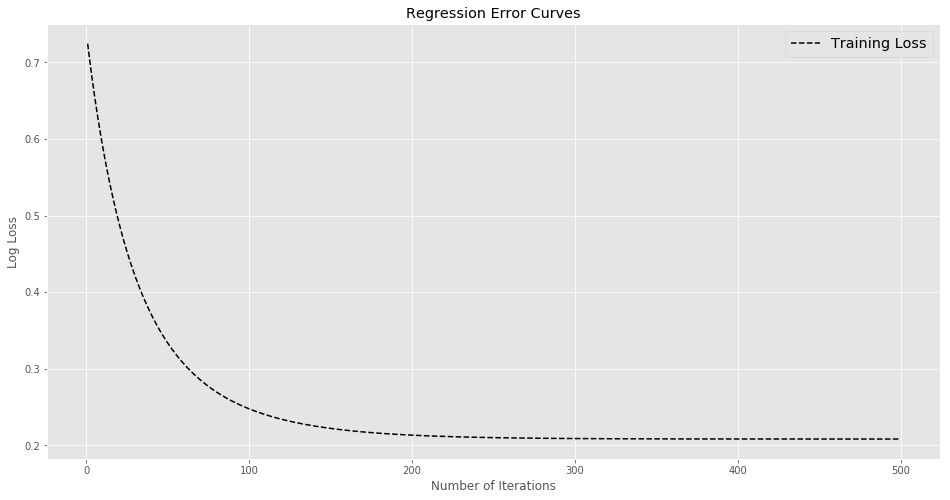

In [15]:
# plot error curve
def plotErrorCurves(trainLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    if title:
        plt.title(title)
    plt.show()
    
trainLoss, models = results
plotErrorCurves(trainLoss, title = 'Regression Error Curves' )

Now that we have our model obtained from gradient descent, lets compare it to a model obtained using Pyspark ML's algorithm.

In [16]:
lr = LogisticRegression(maxIter=50, regParam=0.1, standardization=False, fitIntercept=True, elasticNetParam=0.0)
lrModel = lr.fit(toy_df_transformed)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.9263229990549198,-0.9263228082011592,0.9263229990549198]
Intercept: -0.02859498889738666


We see that from our gradient descent method, we got the regression:

$$
logit(p) = 0.929*feature1 - 0.923*feature2 + 0.928* feature3 - 0.034
$$

And from Pyspark ML, we got the regression:

$$
logit(p) = 0.926*feature1 - 0.926*feature2 + 0.926* feature3 - 0.029
$$

We can see that our two resulting models are very similar. However, it should be noted that Spark ML's Logistic Regression algorithm does not fit the model with Gradient Descent as we did. According to the documentation we found, they approach it with the L-BFGS method which is a quasi-Newton type of optimization algorithm. This approach searches for the optimum model through the variable space by us an estimation to the inverse Hessian matrix as a guide.

Now that we have our two models, lets check if they will make the same predictions.

In [17]:
def find_p(coef, intercept, inputs):
    '''
    Finds the probability of a click through
    Args:
        coef - (array) model coefficients
        intercept - (float) intercept for the model
        inputs - (list) features for a single observation
     Returns:
        p   - (float) the probability of a click through
    '''
    rhs = np.dot(coef, inputs) + intercept
    return 1/(1+np.exp(-1.0*rhs))

lrMod0 = find_p(lrModel.coefficients, lrModel.intercept, [0,1,0])
lrMod1 = find_p(lrModel.coefficients, lrModel.intercept, [1,0,1])
grd_dec0 = find_p(results[1][-1][1:], results[1][-1][0], [0,1,0])
grd_dec1 = find_p(results[1][-1][1:], results[1][-1][0], [1,0,1])

print("When our input is [0,1,0] our resulting p of getting a 1 from Pyspark ML's model is {}".format(lrMod0))
print("When our input is [1,0,1] our resulting p of getting a 1 from Pyspark ML's model is {}".format(lrMod1))
print("When our input is [0,1,0] our resulting p of getting a 1 from gradient descent's model is {}".format(grd_dec0))
print("When our input is [1,0,1] our resulting p of getting a 1 from gradient descent's model is {}".format(grd_dec1))

When our input is [0,1,0] our resulting p of getting a 1 from Pyspark ML's model is 0.27789688952282793
When our input is [1,0,1] our resulting p of getting a 1 from Pyspark ML's model is 0.8610515063750065
When our input is [0,1,0] our resulting p of getting a 1 from gradient descent's model is 0.277437795407699
When our input is [1,0,1] our resulting p of getting a 1 from gradient descent's model is 0.8608821975928538


As shown above, even though the two models have different coefficents, they will both predict 0 when we input <0,1,0> and they will both predict 1 when we input <1,0,1>. 

# 3. EDA and Discussion of Challenges

## Exploratory Data Analysis

To aid in feature selection, transformation and optimization, we first performed an Exploratory Data Analysis to see what we were working with.  In the interest of focus and brevity we will not include the full analysis here, but [you can view it in the Exploratory Data Analysis notebook if you wish](Exploratory%20Data%20Analysis.ipynb).

The data consists of a binary label, 13 numerical columns and 26 categorical columns.  15 of the columns are fully populated, with the remainder containing some proportion of NA values as high as 76%.  From the README provided by Criteo with the dataset, we know the training set consists of one week of data while the test set is a single day, and the rows are in chronological order.


In [46]:
# Pull 10k rows of the data and put it in Pandas for analysis
train_RDD = sc.textFile("gs://w261-final-hoky/data/train.txt")
sample = train_RDD.map(lambda x: x.split('\t')) \
                  .takeSample(False, 10000, seed=261)
df = pd.DataFrame.from_records(sample, columns=["I"+str(x) for x in range(14)]+["C"+str(y) for y in range(1, 27)])
df.head()

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,22,-1,26,0,0,0,22,6,0,...,27c07bd6,1f868fdd,f44bef3c,b1252a9d,98459119,ad3062eb,32c7478e,e18cf978,001f3601,7a1d43a0
1,0,,0,14,7,582312,,0,7,24,...,07c540c4,5aed7436,cd11c728,a458ea53,61f86188,,3a171ecb,b447f3b2,9d93af03,852e35dd
2,0,0,-1,,,4438,,,0,,...,e5ba7672,6acca89e,,,45130880,,32c7478e,488c9489,,
3,1,,4,8,8,8501,,0,29,29,...,776ce399,17a67eff,,,eb37e392,,32c7478e,6042edf0,,
4,0,9,0,18,1,11,1,117,4,185,...,27c07bd6,5bb2ec8e,064f1f80,a458ea53,118d9d51,ad3062eb,32c7478e,9dec18a0,f0f449dd,cb85773a


### Label
The label is binary:  1 means the ad was clicked, 0 means it was not.  25% of the rows are 1s, which is not reflective of the real proportion, which likely has many more 0s than presented here.

In [62]:
col0 = df['I0'].astype(int)
(col0==1).sum()

2509

### Numerical Columns
From the task description, we are told the numeric columns contain count data.  The range of values is extreme, so these will clearly need some normalization.  With some minor variation, all of these columns follow the same pattern:  a range of unique values from dozens to hundreds, but the _vast_ majority either null or 0, with a long positive skew to the distribution of remaining values.  Column I2 is a typical example - a histogram reveals that nearly every value is very low in the distribution:

In [48]:
col2 = df['I2'].astype(int)
len(col2.unique())

862

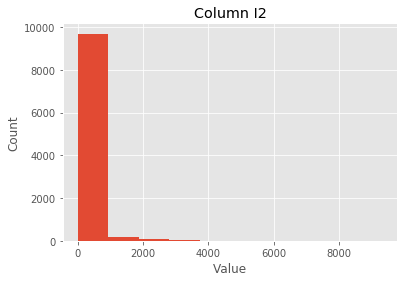

In [49]:
plt.hist(col2)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Column I2")
plt.show()

Viewing it on a logarithmic scale, the scale is clearer, with the first bin nearly two orders of magnitude over the next largest one:

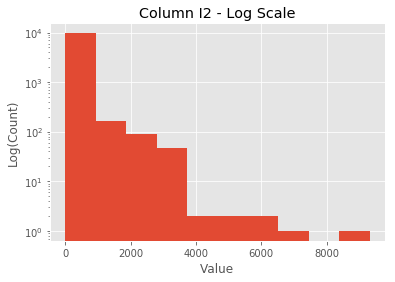

In [50]:
plt.hist(col2, log=True)
plt.xlabel("Value")
plt.ylabel("Log(Count)")
plt.title("Column I2 - Log Scale")
plt.show()

If we focus on just the smallest numbers, the level of skew is even more apparent.

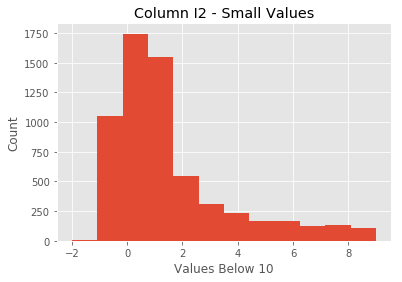

In [51]:
plt.hist(col2[col2<10], bins=12)
plt.xlabel("Values Below 10")
plt.ylabel("Count")
plt.title("Column I2 - Small Values")
plt.show()

Column I2 is unique in that it has -1 and -2 values, but for the most part the numeric columns all echo the shape of this distribution, with minor variations:  some don't have few or no 0 values but start at 1.  One seems to be missing multiples of 3.  There is nothing identifying about any of them.

### Numerical Correlation
We ran a correlation table to see whether there was any correlation between the integer fields and the target variable.

In [52]:
df_i = df.iloc[:,0:14].copy()
df_i.replace('', '-99', inplace=True)
df_i = df_i.astype(int)
corr = df_i.corr()
corr.style.background_gradient(cmap='coolwarm')

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
I0,1,0.147279,0.0422605,0.0133557,-0.0417311,-0.0679078,-0.0477414,0.116107,-0.0354222,0.0250411,0.140741,0.0885897,0.0314593,-0.0564358
I1,0.147279,1,0.0250179,0.0339806,0.171792,-0.240847,0.0441739,0.268878,0.262138,0.193615,0.992386,0.213139,0.183342,0.160156
I2,0.0422605,0.0250179,1,-0.0120274,-0.00126616,-0.00685807,-0.00849512,0.0134443,-0.0307361,-0.00958717,0.0261139,0.0108256,0.0106259,0.00300989
I3,0.0133557,0.0339806,-0.0120274,1,0.062143,-0.00644421,0.0105809,0.00283814,0.0445622,0.0017715,0.0228606,0.00597033,-0.0107266,0.0543534
I4,-0.0417311,0.171792,-0.00126616,0.062143,1,-0.0969428,0.0300801,0.10162,0.344753,0.146729,0.169498,0.204019,0.0617546,0.985745
I5,-0.0679078,-0.240847,-0.00685807,-0.00644421,-0.0969428,1,-0.0472773,-0.132951,-0.128475,-0.085292,-0.241734,-0.221036,-0.0978237,-0.0953971
I6,-0.0477414,0.0441739,-0.00849512,0.0105809,0.0300801,-0.0472773,1,0.0252532,0.0707045,0.225701,0.0517647,0.108363,0.0376442,0.0404948
I7,0.116107,0.268878,0.0134443,0.00283814,0.10162,-0.132951,0.0252532,1,0.129537,0.333835,0.217861,0.570198,0.228557,0.0916359
I8,-0.0354222,0.262138,-0.0307361,0.0445622,0.344753,-0.128475,0.0707045,0.129537,1,0.24351,0.258134,0.133918,0.105866,0.375974
I9,0.0250411,0.193615,-0.00958717,0.0017715,0.146729,-0.085292,0.225701,0.333835,0.24351,1,0.187051,0.275891,0.198845,0.165356


Predictably, none of the columns correlate too closely with the target (I0), however some correlate very closely *with each other*, which makes them good candidates for pruning.

Given that the target variable is binary, we also tried converted the numeric fields to binary (with 1 representing any value that wasn't 0 or null) to see if that might more accurately reflect correlation.

In [53]:
df_b = df.iloc[:,0:14].copy()
df_b = df_b.replace('', '0').replace(regex='^[1-9]\d*$', value='1')
df_b = df_b.astype(int)
corr_b = df_b.corr()
corr_b.style.background_gradient(cmap='coolwarm')

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
I0,1,0.184894,-0.0223243,-0.0562837,-0.0569235,-0.0289084,0.0604534,0.165758,-0.0612372,0.00236014,0.185089,0.166014,0.0429284,-0.11023
I1,0.184894,1,0.00784414,0.0409131,0.106612,-0.0499366,0.186653,0.396537,0.0733186,0.0401349,0.923722,0.40478,0.140407,0.0145989
I2,-0.0223243,0.00784414,1,0.267366,0.304678,0.0218245,0.043155,-0.00669291,0.172172,0.067835,0.00673514,-0.00329911,-0.00909138,0.299688
I3,-0.0562837,0.0409131,0.267366,1,0.447753,0.0160233,0.0783175,0.0234178,0.290273,0.1506,0.0430461,0.0288984,0.0136645,0.43283
I4,-0.0569235,0.106612,0.304678,0.447753,1,0.0360711,0.176202,0.0858295,0.559219,0.347924,0.103636,0.0916093,0.0358627,0.889097
I5,-0.0289084,-0.0499366,0.0218245,0.0160233,0.0360711,1,0.242814,0.141089,0.0615255,0.0879427,-0.062391,0.136047,-0.0148308,0.134274
I6,0.0604534,0.186653,0.043155,0.0783175,0.176202,0.242814,1,0.773572,0.18291,0.378855,0.155043,0.755136,0.0791119,0.237425
I7,0.165758,0.396537,-0.00669291,0.0234178,0.0858295,0.141089,0.773572,1,0.0769539,0.251575,0.367949,0.979888,0.130869,0.0434479
I8,-0.0612372,0.0733186,0.172172,0.290273,0.559219,0.0615255,0.18291,0.0769539,1,0.418794,0.0625869,0.077785,0.0272788,0.550398
I9,0.00236014,0.0401349,0.067835,0.1506,0.347924,0.0879427,0.378855,0.251575,0.418794,1,0.026731,0.245928,0.0342349,0.328054


A number of the target correlations are improved by doing this, as are some correlations between fields.  Simply the presence or absence of information may contain clues for our algorithm to latch onto, so we'll include a binarized version of these columns to see if it improves accuracy.

### Categorical Columns
There are 26 columns of categorical data, all hashed.  The number of unique values per column ranges from 3 to 5900, and given that these columns will need to be one-hot encoded for inclusion in the algorithm, some of the larger ones will need to be pruned or the calculation will become too unwieldy.

There is not much information to be gleaned from examining these columns.  For the most part, they are not broadly distributed and most of the information is covered by a handful of values.

In [60]:
def cat_eda(col):
    '''
    Prints the count, number of unique entries, and most frequent value 
    and its frequency for a single column.
    Args:
        col- column containing data for eda
    '''
    print(df[col].describe())
    top10 = df[col].value_counts()[:10]
    plt.bar(x=np.arange(len(top10)), height=top10.tolist())
    plt.xticks(np.arange(10), top10.index, rotation=90)
    plt.xlabel("Top 10 Values")
    plt.ylabel("Count")
    plt.title(f"Column {col}")
    plt.show()
    print("correlation with target variable:")
    size = len(top10) if len(top10) < 10 else 10
    for cat in range(size):
        col_binary = (df[col].where(df[col]==top10.index[cat])==top10.index[cat]).astype('int')
        correlation = col0.corr(col_binary)
        marker = '(!!!)' if correlation > .1 or correlation < -.1 else ''
        print('{:8}: {} {}'.format(top10.index[cat], correlation, marker))
    top5_share = (np.sum(top10[:5])/10000)*100
    top10_share = (np.sum(top10)/10000)*100
    print("\n{:.2f}% of records are in the top 5, {:.2f}% are in the top 10 ".format(top5_share, top10_share))

count        10000
unique         182
top       05db9164
freq          4982
Name: C1, dtype: object


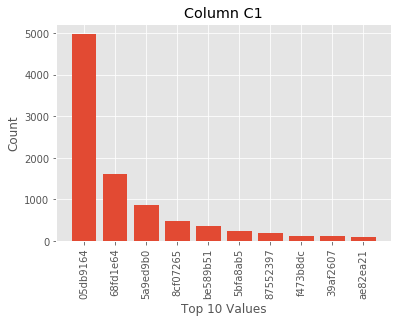

correlation with target variable:
05db9164: 0.007388768573699658 
68fd1e64: 0.0056645789409112525 
5a9ed9b0: -0.0071943377981743785 
8cf07265: -0.013827998046923208 
be589b51: 0.007392746060768605 
5bfa8ab5: 0.0067582360362961145 
87552397: 0.005440488886808017 
f473b8dc: -0.0028287379901573047 
39af2607: 0.0019292943512287822 
ae82ea21: 0.003305814266155385 

83.13% of records are in the top 5, 90.99% are in the top 10 


In [63]:
cat_eda('C1')

We converted the top values to binary (present or not) to check correlation with the target column, but none of them matched up.  Some of the fields are much more broadly distributed with a high number of unique values, and these will be preferentially pruned unless they seem to contain valuable signal.

count        10000
unique        3335
top       1c86e0eb
freq           192
Name: C7, dtype: object


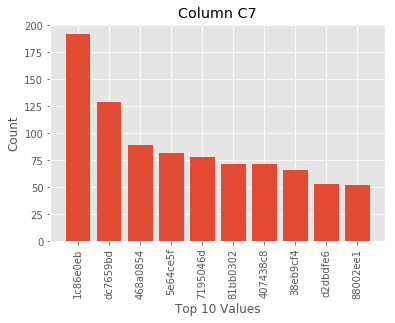

correlation with target variable:
1c86e0eb: 0.058540642925752936 
dc7659bd: -0.010968900612177257 
468a0854: 0.06550092252461748 
5e64ce5f: 0.008763417517692041 
7195046d: 0.008992939135882234 
81bb0302: 0.008753006353176718 
407438c8: 0.011500254196363285 
38eb9cf4: 0.0012551343577738346 
d2dbdfe6: -0.007299432574045383 
88002ee1: -0.03542800538027275 

5.70% of records are in the top 5, 8.83% are in the top 10 


In [64]:
cat_eda('C7')

### Cyclicality
Finally, we wanted to look at temporal patterns in the data.  The README provided by Criteo tells us the records are in chronological order, but none of these fields looks like a timestamp - even in the categoricals. If any of them were a timestamp you would expect to see a repeating pattern in the values, but we couldn't discern one.  As part of feature engineering we'll be adding a daypart column to try and correct this, but we wanted to see if the simple presence of data in the columns showed a pattern.

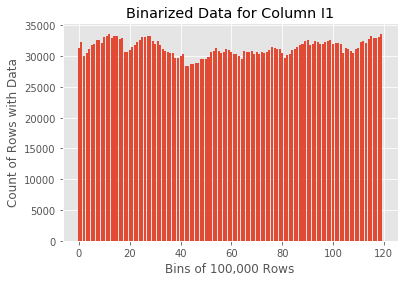

<Figure size 1440x1280 with 0 Axes>

In [66]:
column_names=["I"+str(x) for x in range(14)]+["C"+str(y) for y in range(1, 27)]

def binplot(data, bins):
    '''
    Divide binary data into bins and report number of 1s in each bin
     Args:
        data - (list) list of binary data (1s and 0s)
        bins - (int) desired number of bins
     Returns:
        binlist   - (list) list of length <bins>, with count of 1s for each bin
    '''
    binlist = []
    binsize = int(len(data)/bins)
    for x in range(bins):
        thisbin = np.sum(data[x*binsize:(x+1)*binsize])
        binlist.append(thisbin)
    return binlist

def cat_2days(i):
    '''
    Pull 12m rows of data from train_RDD, binarize it, bin it and show barplot
     Args:
        i - the desired column to display
     Returns:
        A barplot of 120 bins of 100,000 rows with count of 1s for each bin
    '''
    binarize = train_RDD.map(lambda x: x.split('\t')) \
                        .flatMap(lambda x: '0' if x[i] == '0' or x[i] == '' else '1')

    binary_list = binarize.take(12000000)
    binary_list = list(map(int, binary_list))
    
    bingroup = binplot(binary_list, 120)
    plt.xlabel("Bins of 100,000 Rows")
    plt.ylabel("Count of Rows with Data")
    plt.title(f"Binarized Data for Column {column_names[i]}")
    plt.bar(x=np.arange(len(bingroup)), height=bingroup)
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.show()

cat_2days(1)

Here we plot the first 12m rows, which should cover about 2 days of displays.  For many records such as I1 above, there is no clear pattern of data.  And for others, like C1, it's clearly a nonsensical question:

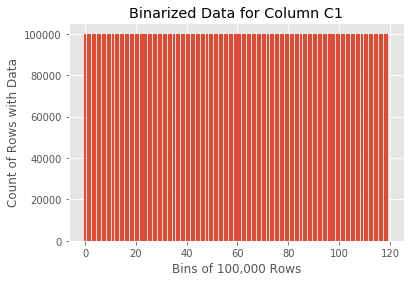

<Figure size 1440x1280 with 0 Axes>

In [67]:
cat_2days(14)

However there are several fields which _do_ show a clear pattern in the data, and while it isn't clear whether this information is useful to the algorithm in addition to the daypart column, in the event that we decide to drop any of these columns from the regression, we can use a binarized form of these columns instead of the full data in order to preserve some of the signal they contain.

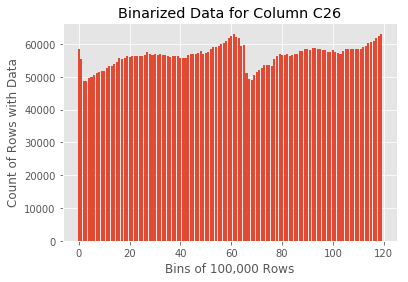

<Figure size 1440x1280 with 0 Axes>

In [68]:
cat_2days(39)

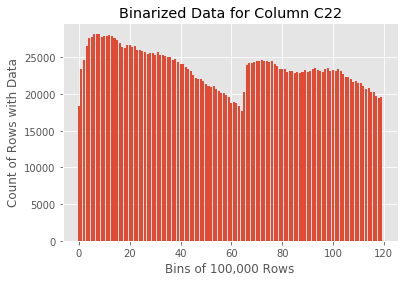

<Figure size 1440x1280 with 0 Axes>

In [69]:
cat_2days(35)

## Feature Engineering

Based on our observations from the Exploratory Data Analysis, some of the features need to be transformed or augmented before they're ready to be run through the Logistic Regression.

### Daypart Feature Addition

The README to the dataset indicates that all the data is in chronological order over a week, but there is nothing in the EDA that looks like a timestamp.  So we decided to add a column `daypart` to fill that function.  Examining the full week of label (click) data as a binned barplot, you can observe seven noticeable cycles in the timing and volume of clicks:

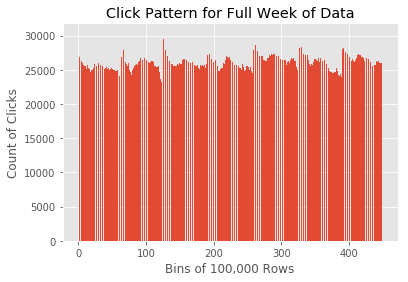

<Figure size 1440x1280 with 0 Axes>

In [70]:
days_RDD = train_RDD.map(lambda x: x.split("\t")) \
                    .flatMap(lambda x: x[0])

days = days_RDD.collect()
days = list(map(int, days))

bin24 = binplot(days, 450)
plt.xlabel("Bins of 100,000 Rows")
plt.ylabel("Count of Clicks")
plt.title("Click Pattern for Full Week of Data")
plt.bar(x=np.arange(len(bin24)), height=bin24)
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.show()

Using a combination of a list of the smallest bins and simple eyeballing, we came up with a list of six breakpoints that look like where the pattern begins to repeat.  We assigned a monotonically increasing index to the entire training data, broke that range into seven chunks, divided each chunk in 24 parts, then wrote a UDF to go through, examine each row's ID and determine which daypart it should go into.  While each day contains a different number of rows, this technique makes buckets that are large enough to capture the repeating volume pattern of clicks. 

In [9]:
# Define the schema prior to loading the data
schema = StructType([StructField("label", IntegerType(), True), StructField("I1", IntegerType(), True),
                     StructField("I2", IntegerType(), True), StructField("I3", IntegerType(), True),
                     StructField("I4", IntegerType(), True), StructField("I5", IntegerType(), True),
                     StructField("I6", IntegerType(), True), StructField("I7", IntegerType(), True),
                     StructField("I8", IntegerType(), True), StructField("I9", IntegerType(), True),
                     StructField("I10", IntegerType(), True), StructField("I11", IntegerType(), True),
                     StructField("I12", IntegerType(), True), StructField("I13", IntegerType(), True),
                     StructField("C1", StringType(), True), StructField("C2", StringType(), True),
                     StructField("C3", StringType(), True), StructField("C4", StringType(), True),
                     StructField("C5", StringType(), True), StructField("C6", StringType(), True),
                     StructField("C7", StringType(), True), StructField("C8", StringType(), True),
                     StructField("C9", StringType(), True), StructField("C10", StringType(), True),
                     StructField("C11", StringType(), True), StructField("C12", StringType(), True),
                     StructField("C13", StringType(), True), StructField("C14", StringType(), True),
                     StructField("C15", StringType(), True), StructField("C16", StringType(), True),
                     StructField("C17", StringType(), True), StructField("C18", StringType(), True),
                     StructField("C19", StringType(), True), StructField("C20", StringType(), True),
                     StructField("C21", StringType(), True), StructField("C22", StringType(), True),
                     StructField("C23", StringType(), True), StructField("C24", StringType(), True),
                     StructField("C25", StringType(), True), StructField("C26", StringType(), True)])

# Load data into dataframe
raw_df = spark.read \
              .option("header", "false") \
              .option("delimiter", "\t") \
              .schema(schema) \
              .csv("gs://w261-final-hoky/data/train.txt")

In [14]:
# Add an index column with sequential ID
raw_df = raw_df.withColumn("index", row_number().over(Window.orderBy(monotonically_increasing_id()))-1).cache()

In [15]:
def make_time(idx):
    '''Compare the index value to a set of breakpoints to assign a daypart to each record'''
    division = 24 # Number of partitions for each day
    
    # Breakpoints that divide the dataset into 7 days
    breakpoints = [0, 63, 122, 189, 258, 324, 389, 458.40617]
    for b in range(len(breakpoints)):
        try:
            # How many rows should be in each daypart?
            increment = ((breakpoints[b+1]*100000)-(breakpoints[b]*100000))/division
            # Establish the breakpoints for the day
            sub_breakpoints = [(breakpoints[b]*100000)+(i*increment) for i in range(division)]
            sub_breakpoints.append(breakpoints[b+1]*100000)

            if idx >= (breakpoints[b]*100000) and idx <= (breakpoints[b+1]*100000):
                print(sub_breakpoints)
                # We're in a day, now assign the daypart
                for b2 in range(len(sub_breakpoints)):
                    if idx >= sub_breakpoints[b2] and idx <= sub_breakpoints[b2+1]:
                        return b2
        except IndexError:
            return breakpoints[b]*100000

maketime_udf = udf(lambda z: make_time(z), IntegerType())


In [16]:
# Apply UDF to the dataset to create daypart
daypart_df = raw_df.withColumn("daypart", maketime_udf('index')).cache()

### NAs, Binarization, Scaling

For the NAs on the numerical columns we have, we decided to impute to the mean from each of those columns. However, we considered that the missing data points are not occuring at random, and that there may be some self-selection bias occurring at the end user level. For example: users omitting information fields, changing their privacy settings, or even deleting their cookies. Simply imputing to the mean would cause us to be missing out on information on the type of users described above. To get around this, we also created an indicator feature for each of the integer columns to indicate whether the record was complete or missing values. Testing indicated that field `C22` also benefited from having one of these columns. For the categorical columns on the other hand, we decided to impute `col_name + _no_value` for each of the records where the information is missing.

For scaling, we first split the data in `train.txt` into a train and test set. We then normalized each of the numerical feature to have unit standard deviation and zero mean. For the scaling, we calculated the mean and standard deviation prior to imputing the values. However we ran onto some issues with the built-in `StandardScaler`, and `VectorAssembler` functions within the spark-ml library. The built-in functions cannot handle a feature with missing values, and there are plenty here. So instead, we scaled the numerical features with Spark SQL as shown below.

In [18]:
# Split the train_df since the test file is not labeled
train_df, test_df = daypart_df.randomSplit([0.8, 0.2], seed=261)

# Register the dataframes to enable us to run SQL against them
train_df.registerTempTable("train")
test_df.registerTempTable("test")

# Checkpoint the train_df and test_df
train_df.checkpoint()
test_df.checkpoint()

DataFrame[label: int, I1: int, I2: int, I3: int, I4: int, I5: int, I6: int, I7: int, I8: int, I9: int, I10: int, I11: int, I12: int, I13: int, C1: string, C2: string, C3: string, C4: string, C5: string, C6: string, C7: string, C8: string, C9: string, C10: string, C11: string, C12: string, C13: string, C14: string, C15: string, C16: string, C17: string, C18: string, C19: string, C20: string, C21: string, C22: string, C23: string, C24: string, C25: string, C26: string, index: int, daypart: int]

In [ ]:
# Scale the numerical features, add indicator columns for blank numerical features, 
# and fill in "no_value" for categorical features.

query = """
SELECT
    t.label,
    t.daypart,
    CASE WHEN t.I1 IS NULL THEN 0 ELSE (t.I1 - MEAN(t.I1) OVER())/STDDEV_SAMP(t.I1) OVER() END AS I1Scaled,
    CASE WHEN t.I2 IS NULL THEN 0 ELSE (t.I2 - MEAN(t.I2) OVER())/STDDEV_SAMP(t.I2) OVER() END AS I2Scaled,
    CASE WHEN t.I3 IS NULL THEN 0 ELSE (t.I3 - MEAN(t.I3) OVER())/STDDEV_SAMP(t.I3) OVER() END AS I3Scaled,
    CASE WHEN t.I4 IS NULL THEN 0 ELSE (t.I4 - MEAN(t.I4) OVER())/STDDEV_SAMP(t.I4) OVER() END AS I4Scaled,
    CASE WHEN t.I5 IS NULL THEN 0 ELSE (t.I5 - MEAN(t.I5) OVER())/STDDEV_SAMP(t.I5) OVER() END AS I5Scaled,
    CASE WHEN t.I6 IS NULL THEN 0 ELSE (t.I6 - MEAN(t.I6) OVER())/STDDEV_SAMP(t.I6) OVER() END AS I6Scaled,
    CASE WHEN t.I7 IS NULL THEN 0 ELSE (t.I7 - MEAN(t.I7) OVER())/STDDEV_SAMP(t.I7) OVER() END AS I7Scaled,
    CASE WHEN t.I8 IS NULL THEN 0 ELSE (t.I8 - MEAN(t.I8) OVER())/STDDEV_SAMP(t.I8) OVER() END AS I8Scaled,
    CASE WHEN t.I9 IS NULL THEN 0 ELSE (t.I9 - MEAN(t.I9) OVER())/STDDEV_SAMP(t.I9) OVER() END AS I9Scaled,
    CASE WHEN t.I10 IS NULL THEN 0 ELSE (t.I10 - MEAN(t.I10) OVER())/STDDEV_SAMP(t.I10) OVER() END AS I10Scaled,
    CASE WHEN t.I11 IS NULL THEN 0 ELSE (t.I11 - MEAN(t.I11) OVER())/STDDEV_SAMP(t.I11) OVER() END AS I11Scaled,
    CASE WHEN t.I12 IS NULL THEN 0 ELSE (t.I12 - MEAN(t.I12) OVER())/STDDEV_SAMP(t.I12) OVER() END AS I12Scaled,
    CASE WHEN t.I13 IS NULL THEN 0 ELSE (t.I13 - MEAN(t.I13) OVER())/STDDEV_SAMP(t.I13) OVER() END AS I13Scaled,
    CASE WHEN t.I1 IS NULL THEN 1 ELSE 0 END AS I1BlankInd,
    CASE WHEN t.I2 IS NULL THEN 1 ELSE 0 END AS I2BlankInd,
    CASE WHEN t.I3 IS NULL THEN 1 ELSE 0 END AS I3BlankInd,
    CASE WHEN t.I4 IS NULL THEN 1 ELSE 0 END AS I4BlankInd,
    CASE WHEN t.I5 IS NULL THEN 1 ELSE 0 END AS I5BlankInd,
    CASE WHEN t.I6 IS NULL THEN 1 ELSE 0 END AS I6BlankInd,
    CASE WHEN t.I7 IS NULL THEN 1 ELSE 0 END AS I7BlankInd,
    CASE WHEN t.I8 IS NULL THEN 1 ELSE 0 END AS I8BlankInd,
    CASE WHEN t.I9 IS NULL THEN 1 ELSE 0 END AS I9BlankInd,
    CASE WHEN t.I10 IS NULL THEN 1 ELSE 0 END AS I10BlankInd,
    CASE WHEN t.I11 IS NULL THEN 1 ELSE 0 END AS I11lankInd,
    CASE WHEN t.I12 IS NULL THEN 1 ELSE 0 END AS I12BlankInd,
    CASE WHEN t.I13 IS NULL THEN 1 ELSE 0 END AS I13BlankInd,
    CASE WHEN t.C1 IS NULL THEN "C1_no_value" ELSE t.C1 END AS C1,
    CASE WHEN t.C2 IS NULL THEN "C2_no_value" ELSE t.C2 END AS C2,  
    CASE WHEN t.C3 IS NULL THEN "C3_no_value" ELSE t.C3 END AS C3,
    CASE WHEN t.C4 IS NULL THEN "C4_no_value" ELSE t.C4 END AS C4,
    CASE WHEN t.C5 IS NULL THEN "C5_no_value" ELSE t.C5 END AS C5,
    CASE WHEN t.C6 IS NULL THEN "C6_no_value" ELSE t.C6 END AS C6,
    CASE WHEN t.C7 IS NULL THEN "C7_no_value" ELSE t.C7 END AS C7,
    CASE WHEN t.C8 IS NULL THEN "C8_no_value" ELSE t.C8 END AS C8,
    CASE WHEN t.C9 IS NULL THEN "C9_no_value" ELSE t.C9 END AS C9,
    CASE WHEN t.C10 IS NULL THEN "C10_no_value" ELSE t.C10 END AS C10,
    CASE WHEN t.C11 IS NULL THEN "C11_no_value" ELSE t.C11 END AS C11,
    CASE WHEN t.C12 IS NULL THEN "C12_no_value" ELSE t.C12 END AS C12,
    CASE WHEN t.C13 IS NULL THEN "C13_no_value" ELSE t.C13 END AS C13,
    CASE WHEN t.C14 IS NULL THEN "C14_no_value" ELSE t.C14 END AS C14,
    CASE WHEN t.C15 IS NULL THEN "C15_no_value" ELSE t.C15 END AS C15,
    CASE WHEN t.C16 IS NULL THEN "C16_no_value" ELSE t.C16 END AS C16,
    CASE WHEN t.C17 IS NULL THEN "C17_no_value" ELSE t.C17 END AS C17,
    CASE WHEN t.C18 IS NULL THEN "C18_no_value" ELSE t.C18 END AS C18,
    CASE WHEN t.C19 IS NULL THEN "C19_no_value" ELSE t.C19 END AS C19,
    CASE WHEN t.C20 IS NULL THEN "C20_no_value" ELSE t.C20 END AS C20,
    CASE WHEN t.C21 IS NULL THEN "C21_no_value" ELSE t.C21 END AS C21,
    CASE WHEN t.C22 IS NULL THEN "C22_no_value" ELSE t.C22 END AS C22,
    CASE WHEN t.C22 IS NULL THEN 1 ELSE 0 END AS C22BlankInd,
    CASE WHEN t.C23 IS NULL THEN "C23_no_value" ELSE t.C23 END AS C23,
    CASE WHEN t.C24 IS NULL THEN "C24_no_value" ELSE t.C24 END AS C24,
    CASE WHEN t.C25 IS NULL THEN "C25_no_value" ELSE t.C25 END AS C25,
    CASE WHEN t.C26 IS NULL THEN "C26_no_value" ELSE t.C26 END AS C26
FROM
    train t
"""

scaled_train_df = spark.sql(query)
scaled_train_df.checkpoint()

In [ ]:
# Scale the numerical features of the test data set using the mean and standard deviation from the train set, 
# add indicator columns for blank numerical features, and fill in "no_value" for categorical features.
query = """
WITH train_fit AS 
    (SELECT
        STDDEV_SAMP(t.I1) AS I1Stddev,
        STDDEV_SAMP(t.I2) AS I2Stddev,
        STDDEV_SAMP(t.I3) AS I3Stddev,
        STDDEV_SAMP(t.I4) AS I4Stddev,
        STDDEV_SAMP(t.I5) AS I5Stddev,
        STDDEV_SAMP(t.I6) AS I6Stddev,
        STDDEV_SAMP(t.I7) AS I7Stddev,
        STDDEV_SAMP(t.I8) AS I8Stddev,
        STDDEV_SAMP(t.I9) AS I9Stddev,
        STDDEV_SAMP(t.I10) AS I10Stddev,
        STDDEV_SAMP(t.I11) AS I11Stddev,
        STDDEV_SAMP(t.I2) AS I12Stddev,
        STDDEV_SAMP(t.I3) AS I13Stddev,
        MEAN(t.I1) AS I1Mean,
        MEAN(t.I2) AS I2Mean,
        MEAN(t.I3) AS I3Mean,
        MEAN(t.I4) AS I4Mean,
        MEAN(t.I5) AS I5Mean,
        MEAN(t.I6) AS I6Mean,
        MEAN(t.I7) AS I7Mean,
        MEAN(t.I8) AS I8Mean,
        MEAN(t.I9) AS I9Mean,
        MEAN(t.I10) AS I10Mean,
        MEAN(t.I11) AS I11Mean,
        MEAN(t.I12) AS I12Mean,
        MEAN(t.I13) AS I13Mean
    FROM
        train t),
test_intermediate AS 
    (SELECT 
        ts.*,
        (SELECT I1Stddev FROM train_fit) AS I1stddev,
        (SELECT I2Stddev FROM train_fit) AS I2stddev,
        (SELECT I3Stddev FROM train_fit) AS I3stddev,
        (SELECT I4Stddev FROM train_fit) AS I4stddev,
        (SELECT I5Stddev FROM train_fit) AS I5stddev,
        (SELECT I6Stddev FROM train_fit) AS I6stddev,
        (SELECT I7Stddev FROM train_fit) AS I7stddev,
        (SELECT I8Stddev FROM train_fit) AS I8stddev,
        (SELECT I9Stddev FROM train_fit) AS I9stddev,
        (SELECT I10Stddev FROM train_fit) AS I10stddev,
        (SELECT I11Stddev FROM train_fit) AS I11stddev,
        (SELECT I12Stddev FROM train_fit) AS I12stddev,
        (SELECT I13Stddev FROM train_fit) AS I13stddev,
        (SELECT I1Mean FROM train_fit) AS I1Mean,
        (SELECT I2Mean FROM train_fit) AS I2Mean,
        (SELECT I3Mean FROM train_fit) AS I3Mean,
        (SELECT I4Mean FROM train_fit) AS I4Mean,
        (SELECT I5Mean FROM train_fit) AS I5Mean,
        (SELECT I6Mean FROM train_fit) AS I6Mean,
        (SELECT I7Mean FROM train_fit) AS I7Mean,
        (SELECT I8Mean FROM train_fit) AS I8Mean,
        (SELECT I9Mean FROM train_fit) AS I9Mean,
        (SELECT I10Mean FROM train_fit) AS I10Mean,
        (SELECT I11Mean FROM train_fit) AS I11Mean,
        (SELECT I12Mean FROM train_fit) AS I12Mean,
        (SELECT I13Mean FROM train_fit) AS I13Mean
    FROM 
        test ts)
SELECT 
    ti.label,
    ti.daypart,
    CASE WHEN ti.I1 IS NULL THEN 0 ELSE (ti.I1 - ti.I1Mean)/I1Stddev END AS I1Scaled,
    CASE WHEN ti.I2 IS NULL THEN 0 ELSE (ti.I2 - ti.I1Mean)/I2Stddev END AS I2Scaled,
    CASE WHEN ti.I3 IS NULL THEN 0 ELSE (ti.I3 - ti.I1Mean)/I3Stddev END AS I3Scaled,
    CASE WHEN ti.I4 IS NULL THEN 0 ELSE (ti.I4 - ti.I1Mean)/I4Stddev END AS I4Scaled,
    CASE WHEN ti.I5 IS NULL THEN 0 ELSE (ti.I5 - ti.I1Mean)/I5Stddev END AS I5Scaled,
    CASE WHEN ti.I6 IS NULL THEN 0 ELSE (ti.I6 - ti.I1Mean)/I6Stddev END AS I6Scaled,
    CASE WHEN ti.I7 IS NULL THEN 0 ELSE (ti.I7 - ti.I1Mean)/I7Stddev END AS I7Scaled,
    CASE WHEN ti.I8 IS NULL THEN 0 ELSE (ti.I8 - ti.I1Mean)/I8Stddev END AS I8Scaled,
    CASE WHEN ti.I9 IS NULL THEN 0 ELSE (ti.I9 - ti.I1Mean)/I9Stddev END AS I9Scaled,
    CASE WHEN ti.I10 IS NULL THEN 0 ELSE (ti.I10 - ti.I1Mean)/I10Stddev END AS I10Scaled,
    CASE WHEN ti.I11 IS NULL THEN 0 ELSE (ti.I11 - ti.I1Mean)/I11Stddev END AS I11Scaled,
    CASE WHEN ti.I12 IS NULL THEN 0 ELSE (ti.I12 - ti.I1Mean)/I12Stddev END AS I12Scaled,
    CASE WHEN ti.I13 IS NULL THEN 0 ELSE (ti.I13 - ti.I1Mean)/I13Stddev END AS I13Scaled,
    CASE WHEN ti.I1 IS NULL THEN 1 ELSE 0 END AS I1BlankInd,
    CASE WHEN ti.I2 IS NULL THEN 1 ELSE 0 END AS I2BlankInd,
    CASE WHEN ti.I3 IS NULL THEN 1 ELSE 0 END AS I3BlankInd,
    CASE WHEN ti.I4 IS NULL THEN 1 ELSE 0 END AS I4BlankInd,
    CASE WHEN ti.I5 IS NULL THEN 1 ELSE 0 END AS I5BlankInd,
    CASE WHEN ti.I6 IS NULL THEN 1 ELSE 0 END AS I6BlankInd,
    CASE WHEN ti.I7 IS NULL THEN 1 ELSE 0 END AS I7BlankInd,
    CASE WHEN ti.I8 IS NULL THEN 1 ELSE 0 END AS I8BlankInd,
    CASE WHEN ti.I9 IS NULL THEN 1 ELSE 0 END AS I9BlankInd,
    CASE WHEN ti.I10 IS NULL THEN 1 ELSE 0 END AS I10BlankInd,
    CASE WHEN ti.I11 IS NULL THEN 1 ELSE 0 END AS I11lankInd,
    CASE WHEN ti.I12 IS NULL THEN 1 ELSE 0 END AS I12BlankInd,
    CASE WHEN ti.I13 IS NULL THEN 1 ELSE 0 END AS I13BlankInd,
    CASE WHEN ti.C1 IS NULL THEN "C1_no_value" ELSE ti.C1 END AS C1,
    CASE WHEN ti.C2 IS NULL THEN "C2_no_value" ELSE ti.C2 END AS C2,  
    CASE WHEN ti.C3 IS NULL THEN "C3_no_value" ELSE ti.C3 END AS C3,
    CASE WHEN ti.C4 IS NULL THEN "C4_no_value" ELSE ti.C4 END AS C4,
    CASE WHEN ti.C5 IS NULL THEN "C5_no_value" ELSE ti.C5 END AS C5,
    CASE WHEN ti.C6 IS NULL THEN "C6_no_value" ELSE ti.C6 END AS C6,
    CASE WHEN ti.C7 IS NULL THEN "C7_no_value" ELSE ti.C7 END AS C7,
    CASE WHEN ti.C8 IS NULL THEN "C8_no_value" ELSE ti.C8 END AS C8,
    CASE WHEN ti.C9 IS NULL THEN "C9_no_value" ELSE ti.C9 END AS C9,
    CASE WHEN ti.C10 IS NULL THEN "C10_no_value" ELSE ti.C10 END AS C10,
    CASE WHEN ti.C11 IS NULL THEN "C11_no_value" ELSE ti.C11 END AS C11,
    CASE WHEN ti.C12 IS NULL THEN "C12_no_value" ELSE ti.C12 END AS C12,
    CASE WHEN ti.C13 IS NULL THEN "C13_no_value" ELSE ti.C13 END AS C13,
    CASE WHEN ti.C14 IS NULL THEN "C14_no_value" ELSE ti.C14 END AS C14,
    CASE WHEN ti.C15 IS NULL THEN "C15_no_value" ELSE ti.C15 END AS C15,
    CASE WHEN ti.C16 IS NULL THEN "C16_no_value" ELSE ti.C16 END AS C16,
    CASE WHEN ti.C17 IS NULL THEN "C17_no_value" ELSE ti.C17 END AS C17,
    CASE WHEN ti.C18 IS NULL THEN "C18_no_value" ELSE ti.C18 END AS C18,
    CASE WHEN ti.C19 IS NULL THEN "C19_no_value" ELSE ti.C19 END AS C19,
    CASE WHEN ti.C20 IS NULL THEN "C20_no_value" ELSE ti.C20 END AS C20,
    CASE WHEN ti.C21 IS NULL THEN "C21_no_value" ELSE ti.C21 END AS C21,
    CASE WHEN ti.C22 IS NULL THEN "C22_no_value" ELSE ti.C22 END AS C22,
    CASE WHEN ti.C22 IS NULL THEN 1 ELSE 0 END AS C22BlankInd,
    CASE WHEN ti.C23 IS NULL THEN "C23_no_value" ELSE ti.C23 END AS C23,
    CASE WHEN ti.C24 IS NULL THEN "C24_no_value" ELSE ti.C24 END AS C24,
    CASE WHEN ti.C25 IS NULL THEN "C25_no_value" ELSE ti.C25 END AS C25,
    CASE WHEN ti.C26 IS NULL THEN "C26_no_value" ELSE ti.C26 END AS C26
FROM 
    test_intermediate ti
"""

scaled_test_df = spark.sql(query).cache()
scaled_test_df.checkpoint()


# 4. Algorithm Implementation

To actually implement the logistic regression, we will be taking advantage of Spark ML, a machine learning library based on Spark's dataframes. This library is optimized for parallel computing, and implements the regression in much the same way as we show in the calculations on the toy set, above.

## Spark ML Pipeline on Toy Dataset

Let's look at our transformation pipeline on a toy example, `dataset`. This toy example is modified from the Spark ML documentation, and contains both categorical and numeric features. This is slightly different from the toy example above, which only contained numeric values.

When we one-hot encode our countries, the countries are assigned the following indices: {NZ: 0, CA: 1, US: 2, Unseen: 3}.  The `HandleInvalid` attribute is set to `keep`, which will add the last, `Unseen` category. This way, when we transform a dataset that contains a country that was not in the training set, we will have somewhere to keep the information. 

To add interactions, we use the RFormula, which creates a list of feature values in the following order: [NZ, CA, US, Unseen, Hour, NZ\*Hour, CA\*Hour, US\*Hour, Unseen\*Hour]. Here, `hour` should be scaled so that we avoid convergence issues with gradient descent.

Note, it is also possible to create interaction features simply by using RFormula directly on the country column. Spark ML does the one-hot encoding under the covers. However, in this case, we wanted more control over how to one hot encode (keeping a column for unseen categories, keeping the last column of the features within a field), so we explicitly one hot encoded.

In [4]:
# First, create the toy dataset, dataset
dataset = spark.createDataFrame(
    [(7, "US", 18, 1.0),
     (8, "CA", 12, 0.0),
     (9, "NZ", 15, 0.0)],
    ["id", "country", "hour", "clicked"])
dataset.cache()

# Set empty stages
stages = []

# Pipeline step 1: one hot encoding for the categorical variables
# cast each record in in categorical column c to an index
c='country'
stridx = StringIndexer(inputCol=c, outputCol = c + "idx").setHandleInvalid("keep")
# one hot encode the indexed categorical column
encoder = OneHotEncoderEstimator(inputCols=[stridx.getOutputCol()], outputCols=[c + "classVec"]).setDropLast(False)
stages += [stridx, encoder]

# Pipeline step 2: Standardize the numerical features
n='hour'
num_assembler = VectorAssembler(inputCols=[n], outputCol=n+"classVec")
num_scaler = StandardScaler(inputCol=num_assembler.getOutputCol(), outputCol=n+"scaled", withMean=True)
stages += [num_assembler, num_scaler]

# Pipeline step 3: create interactions
formula = RFormula(
    formula="clicked ~ countryclassVec + hour + countryclassVec:hour ",
    featuresCol="features",
    labelCol="label")
stages +=[formula]

# Fill pipeline with stages
pipeline = Pipeline(stages=stages)

# Train the transformations on train data. 
# No test set for the toy example, here. Transform the same set we fit.
dataset_transformed = pipeline.fit(dataset).transform(dataset)

# Show results of transformations
pd.DataFrame(dataset_transformed.collect(), columns=dataset_transformed.columns).transpose()

,0,1,2
id,7,8,9
country,US,CA,NZ
hour,18,12,15
clicked,1,0,0
countryidx,2,1,0
countryclassVec,"(0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)"
hourclassVec,[18.0],[12.0],[15.0]
hourscaled,[1.0],[-1.0],[0.0]
features,"(0.0, 0.0, 1.0, 0.0, 18.0, 0.0, 0.0, 18.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 12.0, 0.0, 12.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 15.0, 15.0, 0.0, 0.0, 0.0)"
label,1,0,0


To fit a model, Spark ML take a sparse feature vector, which is assembled by `RFormula`. An example `features` vector is shown in the output, below. 

In [21]:
pd.DataFrame(dataset_transformed.collect(), columns=dataset_transformed.columns)['features'][0]

SparseVector(9, {2: 1.0, 4: 18.0, 7: 18.0})

Once we have our column of features vectors and the labels, we can fit a logistic regression with gradient descent, using Spark ML's pipeline. For this example, we are not optimizing the logistic regression hyperparameters, but there are several of interest.

As mentioned in the algorithm description in section 2, Spark ML uses elastic net regularization with an `elasticNetParam`. We can set this to 0 if we want L2 regularization, or we could it set it to 1 if we want L1 regularization. Anything in the middle will yield a combination of the two. `regParam` will update the regularization parameter, $\lambda$, from equations 6 to 9. 

Spark ML, however does not have the option to change the learning rate within logistic regression, since it decreases the learning rate with each iteration. [spark docs] Additionally, Spark ML randomizes the starting vector for gradient descent, so we do not control the intial vector of weights.

Below, we fit the model to the toy data through the Spark ML pipeline and evaluate the results. Though, in general, we avoid UDFs to improve scalabiility, we use one for calculating the log loss. We do this because it is not possible to disassemble the vector to access the values inside without converting to an RDD or otherwise involving python. So, in this case, we calculate the log loss using the UDF below. Note that the actual calculations are similar to the RDD implementation from the **Algorithm Description** section.

For each model we evaluate the accuracy, f1-score, logloss, and the confusion matrix. We want to maximize accuracy and f1-score, and minimize the logloss. We evaluate the confusion matrix to make sure that the model actually predicts clicks instead of predicting the majority class.

For reference, the f1-score for each class is calculated from a combination of precision and recall, with definitions shown below. The f1-scores for each class are averaged to yield a final f1-score. We do this instead of taking the weighted average to emphasize the prediction quality on the minority class.

\begin{equation}
\text {Precision}=\frac{\text {TP}}{\text {TP}+\text {FP}}
\end{equation}


\begin{equation}
\text{Recall}=\frac{\text {TP}}{\text {TP}+\text {FN}}
\end{equation}

\begin{equation}
f1=2 \times \frac{\text {precision} \times \text {recall}}{\text {precision}+\text {recall}},
\end{equation}

where TP = True Positives, FP = False Positives, and FN = False Negatives. 


In [7]:
def computeLogLoss(prob, label):
    ''' Calculates the log loss for a single observation
    Args:
        prob- float, a probability between 0 and 1
        label- integer, a label that is either 0 or 1
    Output:
        logloss- float, the log loss value for the single observation
    '''
    # for the special case when prob=0 or 1, need a small value to avoid log(0)
    prob = prob[int(label)]
    eps = 10e-14
    if prob == 0:
        prob += eps
    if prob == 1:
        prob -= eps
    return -label * np.log(prob) - (1 - label) * np.log(1-prob)

def printMetrics(predictions_and_labels):
    ''' 
    Prints the metrics to evaluate performance of a model.
    Note: Using the RDD based metrics because documentation on the dataframe API
    metrics indicates a limited number of built in metrics. A UDF would be just as 
    inefficient as using the RDD-based API.
    '''
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Precision of True ', metrics.precision(1))
    print('Precision of False', metrics.precision(0))
    print('Recall of True    ', metrics.recall(1))
    print('Recall of False   ', metrics.recall(0))
    print('F-1 Score         ', metrics.weightedFMeasure())
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())

In [7]:
stages = []
# Pipeline step 5: run the logistic regression
lr = LogisticRegression(featuresCol='features', labelCol ='label', regParam=0.5, maxIter=50, fitIntercept=True)
stages += [lr]

# Can use these to troubleshoot or summarize which model and which transformations are used.
# print(lr.explainParams())
# print('stages:\n', stages)

# fit the pipeline to do the series of fit/transform defined in stages
start = time.time()
pipeline = Pipeline(stages=stages)

# Train the transformations on train data
pipelineModelTrain = pipeline.fit(dataset_transformed)

# Make predictions on test data
predictions_df = pipelineModelTrain.transform(dataset_transformed)

print(f"... executed pipeline in {time.time() - start} seconds")

pred_rdd = predictions_df.select(["prediction", "label"]).rdd
printMetrics(pred_rdd)

# Calculate logloss
start = time.time()
loglossUDF = udf(lambda x: float(computeLogLoss(x[0], x[1])), returnType=FloatType())
newdf = predictions_df.withColumn('logloss', loglossUDF(struct('probability', 'label')))
newdf.select(avg(col("logloss"))).show()
print(f"... calculated average log loss in {time.time() - start} seconds")

... executed pipeline in 1.230384349822998 seconds
Precision of True  1.0
Precision of False 1.0
Recall of True     1.0
Recall of False    1.0
F-1 Score          1.0
Confusion Matrix
 [[2. 0.]
 [0. 1.]]
+------------------+
|      avg(logloss)|
+------------------+
|1.3497655590375264|
+------------------+

... calculated average log loss in 1.1551170349121094 seconds


## Feature Selection
It is not viable to include every feature in the final regression.  Several of the categorical features contain thousands of unique values over a broad distribution, and they would need to be one-hot encoded out to a very sparse matrix to be included, which would break the memory limits of our cluster (we know because we tried).  It might also very well be the case that including everything is not what we would want even with limitless memory, as some of the features might work against each other in the regression to bring down accuracy.

We spent a lot of time on feature selection, which we detail in the [accompanying Feature Selection and Optimization notebook](Feature%20Selection%20and%20Optimization.ipynb).  We'll summarize our findings here.

After feature engineering, we have:
- 27 categorical columns (C1-C26, daypart)
- 14 continuous integer columns (I1-13, index)
- 14 binary integer columns (I1-I13, C22)

That makes 55 columns total.  

### Run on Everything
We were unable to run all these columns on the full dataset without running out of memory, but we did manage it on a 10% sample of the data:

In [ ]:
Accuracy: 0.6851745996536162
Log Loss:  0.9483030295010226
... Single regression run in 1567.0638630390167 seconds

### Handpicked Features

Using the data from the EDA, we hand-picked a set of columns that looked like they might add value: categorical columns that are not too homogenous, empty, or contain too many unique values, and numerical columns that don't correlate too strongly with each other.
- Categorical: ["daypart", "C1", "C5", "C6", "C8", "C9", "C10", "C14", "C17", "C19", "C20", "C22", "C23", "C25"]
- Numerical:  ['I1Scaled', 'I2Scaled', 'I3Scaled', 'I4Scaled', 'I5Scaled', 'I6Scaled', 'I7Scaled', 'I8Scaled', 'I9Scaled', 'I10Scaled', 'I11Scaled', 'I12Scaled']
- Binary: ['I1BlankInd', 'I2BlankInd', 'I3BlankInd', 'I4BlankInd', 'I5BlankInd', 'I6BlankInd', 'I7BlankInd', 'I8BlankInd', 'I9BlankInd', 'I10BlankInd', 'I11BlankInd', 'I12BlankInd', 'C22BlankInd']

In [ ]:
Accuracy: 0.6686519565114537
Log Loss:  0.754654385671807
... Single regression run in 225.16059064865112 seconds

### Systematically Optimized Features
The handpicked set ran much faster than the full set, even on 100% of the data, but the accuracy took a hit.  Without any other clues to go on, we built an iterative function to train repeatedly on a sample of data and systematically remove one feature at a time to see which removal resulted in the most improvement to accuracy.  Once any potential removal would no longer improve the score, it was done.  To avoid overfitting on a small subset of data, we ran the function on three separate samples, and chose any column that was identified as meaningful on a sample.  Running through this, we arrived at an optimized set of features.

- Categorical: ['daypart', 'C1', 'C2', 'C5', 'C6', 'C7', 'C8', 'C11', 'C13', 'C14', 'C15', 'C17', 'C18', 'C19', 'C20', 'C22', 'C26']
- Numeric: ['I1Scaled', 'I2Scaled', 'I3Scaled', 'I4Scaled', 'I5Scaled', 'I6Scaled', 'I7Scaled', 'I8Scaled', 'I11Scaled', 'I12Scaled', 'I13Scaled']
- Binary: ['I1BlankInd', 'I3BlankInd', 'I5BlankInd', 'I6BlankInd', 'I7BlankInd', 'I9BlankInd', 'I10BlankInd', 'I11lankInd', 'I12BlankInd', 'C22BlankInd']

Our selection was not entirely automated as we removed categorical columns with more than 10,000 unique values before running the optimizer.  Removing these columns speeds up the training enormously at small cost to accuracy, so we omitted them from the final set of features, which gave us the following score:

In [ ]:
Accuracy: 0.6830073962852925
Log Loss:  0.8667510902837625
... Single regression run in 406.1963346004486 seconds

### Interactions
We found the highest-value features taken independently, but is there additional information that can be derived by looking at them in combination? For example, one of the numericals might be number of times this user has visited this site, while one of the categoricals might be the referring URL, and perhaps heavy users of _this_ site who just came from _that_ site are more likely to click on a particular ad. In order to examine that, we would need an interaction term.

In order to determine interactions, we went through a similar iterative process to feature selection.  Interactions on categorical features with high numbers of unique values get unwieldy quickly, so we limited the search to the numerical features and these smaller categoricals: ['daypart', 'C5', 'C6', 'C8', 'C14', 'C17', 'C20', 'C22'].  Again, using different samples of data, we tested the addition of the interactions to the overall regression one-by-one, and kept track of those that had a positive effect on score.  From this we determined a list of interactions that, in isolation, were beneficial:  [C5/C17, C6/C17, C8/C17, C14/C17, C17/C20, C17/C22].

Interestingly, `C17` proved a key column, improving the score via interactions with several other columns.  Including more than one of these at a time, however, diminished the effect, so ultimately we wound up with the single most valuable interaction:  `C6` with `C17`.  Adding this to the regression and using the full balanced dataset gave us the following score:

In [ ]:
Accuracy: 0.6908240349089844
Log Loss:  0.8542615411319706
... Single regression run in 346.16791677474976 seconds

## Hyperparameter Tuning

Here we discuss several of the hyperparameters that we selected for our logistic regression. These were determined through several experiments or theory.

### fitIntercept=True
While specifying the model not to fit an intercept technically improved our log loss metric, it isn't proper in this context.  As shown above in the **Log Loss** section, if we leave out the intercept of the model, we will be claiming that when all the predictors are zero, the probability of getting a click on the ad will be 0.5. That is why we can not exclude the intercept in our regression.

### maxIter=4
After four iterations, our Log Loss would start to increase, an indication of overfitting.

### elasticNetParam=0
This hyperparameter covers regularization, and 0 indicates an L2 (Ridge) penalty.  Because we were fairly aggressive in filtering out features before they went into the model, we did not rely on Lasso regularization to remove features for us.  This helped us keep the training cycle relatively fast.

### regParam=0.5
The regularization parameter to apply the penalty.  We set this through trial-and-error.

## Final Model Evaluation
For feature engineering, selection, optimization and testing, we used a dataset with labels that were balanced between 1s and 0s, to isolate simple majority class probability from the equation.  However for evaluation, we present the model's performance on both balanced and unbalanced data.  Since the official test set does not have any labels, we can present our model's results on that set but we cannot evaluate them, so do not complete that exercise here.

In [8]:
def runRegressionWithInteractions(num, cat, train, test, inters=[]):
    ''' Runs features through a pipeline into a Logistic Regression
    Args:
        num_feats - list of column names for numeric features
        cat_feats - list of column names for categorical features
        train - dataframe for training
        test - dataframe for testing
    Output:
        predictions - test dataframe with column of predictions from the logistic regression
    '''
    # Pipeline step 1: one hot encoding for the categorical variables
    stages = []
    for c in cat:
        # cast each record in in categorical column c to an index
        stridx = StringIndexer(inputCol=c, outputCol = c + "idx").setHandleInvalid("keep")
        # one hot encode the indexed categorical column
        encoder = OneHotEncoderEstimator(inputCols=[stridx.getOutputCol()], outputCols=[c + "classVec"]).setDropLast(False)
        stages += [stridx, encoder]

    # Pipeline step 3: index the label column
    label_stridx = StringIndexer(inputCol="label", outputCol="label_transformed").setHandleInvalid('skip')
    stages += [label_stridx]

    # Pipeline step 4: add interactions, and store in a features vector as type of sparse vector

    # Get string to indicate all terms we want in our function
    assembler_inputs = [c + "classVec" for c in cat] + [n for n in num]
    formula_string='label ~ ' + (' + ').join(assembler_inputs)
    
    if inters:
        for inter in inters:
            i1 = inter[0]+"classVec" if inter[0][0]=="C" and inter[0]!="C22Bin" else inter[0]
            i2 = inter[1]+"classVec" if inter[1][0]=="C" and inter[1]!="C22Bin" else inter[1]
            formula_string += ' + ' + i1 + ':' + i2
        
    #print(formula_string)
    
    # Create formula for the function
    formula = RFormula(formula=formula_string, featuresCol='features', labelCol='label')
    stages +=[formula]

    # Add the model to the pipeline
    lr = LogisticRegression(featuresCol='features', labelCol ='label_transformed', maxIter=4, regParam=.05, elasticNetParam=0, standardization=True)
    stages += [lr]

    # fit the pipeline to do the series of fit/transform defined in stages
    pipeline = Pipeline(stages=stages)

    # Train the model
    pipelineModel = pipeline.fit(train)

    # Make predictions
    predictions_df = pipelineModel.transform(test)
   
    return predictions_df


# Our chosen subset of features for the model:
cat_feats = ['daypart', 'C2', 'C6', 'C9', 'C11', 'C13', 'C14', 'C15', 'C17', 'C18', 'C19', 'C22', 'C23']
num_feats = ['I1Scaled', 'I2Scaled', 'I3Scaled', 'I4Scaled', 'I6Scaled', 'I7Scaled', 
             'I8Scaled', 'I9Scaled', 'I10Scaled', 'I11Scaled', 'I12Scaled']
num_feats += ['I1BlankInd', 'I3BlankInd', 'I5BlankInd', 'I6BlankInd', 'I7BlankInd', 
              'I9BlankInd', 'I10BlankInd', 'I11BlankInd', 'I12BlankInd', 'C22BlankInd']
interactions = [('daypart', 'I6Scaled'), ('C2', 'I6Scaled'), ('C2', 'I11Scaled'), ('C6', 'C23'), 
                ('C9', 'I6Scaled'), ('C14', 'I6Scaled'), ('C17', 'I6Scaled')]

### Dummy Classifier

We fit a dummy classifier, which predicts the majority class for each observation with 100 % probability.

In [8]:
# Load dummy dataframe
dummy_df = spark.read.option("header", "false").parquet("gs://w261-final-hoky/data/cross_validation_data_set/set_3/test/")
dummy_df.registerTempTable("dummy")

start = time.time()

# Put the majority class for all prediction
query = """
SELECT
    0 AS prediction,
    1.0 AS prob_0,
    0.0 AS prob_1,
    d.label
FROM 
    dummy d
"""
dummy_df = spark.sql(query).cache()

# Transform the the label and prediction column
label_stridx = StringIndexer(inputCol="label", outputCol="label_transformed")
predict_stridx = StringIndexer(inputCol="prediction", outputCol="prediction_transformed")
probability_assembler = VectorAssembler(inputCols=["prob_0", "prob_1"], outputCol="probability")

pipeline = Pipeline(stages=[label_stridx, predict_stridx, probability_assembler])
dummy_df = pipeline.fit(dummy_df).transform(dummy_df)

# Print out performance metrics
results_rdd = dummy_df.select(["prediction_transformed", "label_transformed"]).rdd
printMetrics(results_rdd)

# Calculate and show logloss
loglossUDF = udf(lambda x: float(computeLogLoss(x[0], x[1])), returnType=FloatType())
newdf = dummy_df.withColumn('logloss', loglossUDF(struct('probability', 'label')))
newdf.select(avg(col("logloss"))).show()

print(f"... Dummy-Classifier run in {time.time() - start} seconds")

Precision of True  0.0
Precision of False 0.7440352352151381
Recall of True     0.0
Recall of False    1.0
F-1 Score          0.4266170890310920
Confusion Matrix
 [[6818856.       0.]
 [2345839.       0.]]
+-----------------+
|     avg(logloss)|
+-----------------+
|29.93337578250248|
+-----------------+

... Dummy-Classifier run in 148.37330269813538 seconds


## Model Training with Cross Validation

Next, we train the final model on either the class balanced dataset or (for curiosity's sake) the original dataset, and then fit to the original test set or (for curiosity's sake) the balanced test set. We do this with a 5-fold cross validation to check the variance of our fitted models. In general, we see that the variance of the models is quite low, with very similar results from each of the cross validation folds.

### Trained on Balanced, Tested on Balanced Data

In [5]:
# Run Cross-Validated model evaluation with BALANCED training data on BALANCED test
cat_feats = ['daypart', 'C1', 'C2', 'C5', 'C6', 'C7', 'C8', 'C11', 'C13', 
             'C14', 'C15', 'C17', 'C18', 'C19', 'C20', 'C22', 'C26']
num_feats = ['I1Scaled', 'I2Scaled', 'I3Scaled', 'I4Scaled', 'I5Scaled', 'I6Scaled', 'I7Scaled', 'I8Scaled', 
             'I11Scaled', 'I12Scaled', 'I13Scaled', 'I1BlankInd', 'I3BlankInd', 'I5BlankInd', 'I6BlankInd', 
             'I7BlankInd', 'I9BlankInd', 'I10BlankInd', 'I11BlankInd', 'I12BlankInd', 'C22BlankInd']
interactions = [('C6', 'C17')]
results = []
start = time.time()
for CV_set in range(1, 6):
    trainset = "gs://w261-final-hoky/data/cross_validation_data_set/balanced_set_"+str(CV_set)+"/train/"
    testset = "gs://w261-final-hoky/data/cross_validation_data_set/balanced_set_"+str(CV_set)+"/test/"
    train_df = spark.read.option("header", "false").parquet(trainset)
    test_df = spark.read.option("header", "false").parquet(testset)
    train_df.cache()
    test_df.cache()
    
    predictions_df = runRegressionWithInteractions(num_feats, cat_feats, train_df, test_df, interactions)
    score = returnMetrics(predictions_df)
    print(f"Accuracy for set {CV_set}: {score[0]}")
    print(f"Log Loss for set {CV_set}: {score[1]}\n")
    
    results = results.union(predictions_df) if results else predictions_df

# Convert to RDD to print complete metrics
results_rdd = results.select(["prediction", "label_transformed"]).rdd
printMetrics(results_rdd)
print(f"... Total Cross-Validated run in {time.time() - start} seconds")

Accuracy for set 1: 0.6910082479503615
Log Loss for set 1: 0.8536549623519875

Accuracy for set 2: 0.6909831978966476
Log Loss for set 2: 0.8538127788145157

Accuracy for set 3: 0.6904710851853004
Log Loss for set 3: 0.8550057711334526

Accuracy for set 4: 0.6906207365968081
Log Loss for set 4: 0.8522126511312598

Accuracy for set 5: 0.6905541717786448
Log Loss for set 5: 0.8530239266314799

Precision of True  0.7069914704921786
Precision of False 0.6768331871934024
Recall of True     0.6514409772396381
Recall of False    0.7300140514152975
F-1 Score          0.690249435395168
Confusion Matrix
 [[8568099. 3168797.]
 [4091001. 7645895.]]
... Total Cross-Validated run in 1480.1901302337646 seconds


### Trained on Balanced, Tested on Unbalanced Data

In [10]:
# Run Cross-Validated model evaluation with BALANCED training data on UNBALANCED test
cat_feats = ['daypart', 'C1', 'C2', 'C5', 'C6', 'C7', 'C8', 'C11', 'C13', 
             'C14', 'C15', 'C17', 'C18', 'C19', 'C20', 'C22', 'C26']
num_feats = ['I1Scaled', 'I2Scaled', 'I3Scaled', 'I4Scaled', 'I5Scaled', 'I6Scaled', 'I7Scaled', 'I8Scaled', 
             'I11Scaled', 'I12Scaled', 'I13Scaled', 'I1BlankInd', 'I3BlankInd', 'I5BlankInd', 'I6BlankInd', 
             'I7BlankInd', 'I9BlankInd', 'I10BlankInd', 'I11BlankInd', 'I12BlankInd', 'C22BlankInd']
interactions = [('C6', 'C17')]
results = []
start = time.time()
for CV_set in range(1, 6):
    trainset = "gs://w261-final-hoky/data/cross_validation_data_set/balanced_set_"+str(CV_set)+"/train/"
    testset = "gs://w261-final-hoky/data/cross_validation_data_set/set_"+str(CV_set)+"/test/"
    train_df = spark.read.option("header", "false").parquet(trainset)
    test_df = spark.read.option("header", "false").parquet(testset)
    train_df.cache()
    test_df.cache()
    
    predictions_df = runRegressionWithInteractions(num_feats, cat_feats, train_df, test_df, interactions)
    score = returnMetrics(predictions_df)
    print(f"Accuracy for set {CV_set}: {score[0]}")
    print(f"Log Loss for set {CV_set}: {score[1]}\n")
    
    results = results.union(predictions_df) if results else predictions_df

# Convert to RDD to print complete metrics
results_rdd = results.select(["prediction", "label_transformed"]).rdd
printMetrics(results_rdd)
print(f"... Total Cross-Validated run in {time.time() - start} seconds")

Accuracy for set 1: 0.7083156590806539
Log Loss for set 1: 0.9629934231484193

Accuracy for set 2: 0.7092321173412258
Log Loss for set 2: 0.9628230923929499

Accuracy for set 3: 0.7093607588686803
Log Loss for set 3: 0.9646067583893108

Accuracy for set 4: 0.7073435429573942
Log Loss for set 4: 0.9617774045314033

Accuracy for set 5: 0.7078682330126151
Log Loss for set 5: 0.9619883839616282

Precision of True  0.45192762249587815
Precision of False 0.8585094851192203
Recall of True     0.6514409772396381
Recall of False    0.7280399046009992
F-1 Score          0.660778109552003
Confusion Matrix
 [[24822605.  9272511.]
 [ 4091001.  7645895.]]
... Total Cross-Validated run in 1587.3708455562592 seconds


### Trained on Unbalanced, Tested on Unbalanced Data

In [9]:
# Run Cross-Validated model evaluation with UNBALANCED training data on UNBALANCED test
cat_feats = ['daypart', 'C1', 'C2', 'C5', 'C6', 'C7', 'C8', 'C11', 'C13', 
             'C14', 'C15', 'C17', 'C18', 'C19', 'C20', 'C22', 'C26']
num_feats = ['I1Scaled', 'I2Scaled', 'I3Scaled', 'I4Scaled', 'I5Scaled', 'I6Scaled', 'I7Scaled', 'I8Scaled', 
             'I11Scaled', 'I12Scaled', 'I13Scaled', 'I1BlankInd', 'I3BlankInd', 'I5BlankInd', 'I6BlankInd', 
             'I7BlankInd', 'I9BlankInd', 'I10BlankInd', 'I11BlankInd', 'I12BlankInd', 'C22BlankInd']
interactions = [('C6', 'C17')]
results = []
start = time.time()
for CV_set in range(1, 6):
    trainset = "gs://w261-final-hoky/data/cross_validation_data_set/set_"+str(CV_set)+"/train/"
    testset = "gs://w261-final-hoky/data/cross_validation_data_set/set_"+str(CV_set)+"/test/"
    train_df = spark.read.option("header", "false").parquet(trainset)
    test_df = spark.read.option("header", "false").parquet(testset)
    train_df.cache()
    test_df.cache()
    
    predictions_df = runRegressionWithInteractions(num_feats, cat_feats, train_df, test_df, interactions)
    score = returnMetrics(predictions_df)
    print(f"Accuracy for set {CV_set}: {score[0]}")
    print(f"Log Loss for set {CV_set}: {score[1]}\n")
    
    results = results.union(predictions_df) if results else predictions_df

# Convert to RDD to print complete metrics
results_rdd = results.select(["prediction", "label_transformed"]).rdd
printMetrics(results_rdd)
print(f"... Total Cross-Validated run in {time.time() - start} seconds")

Accuracy for set 1: 0.7670514045618169
Log Loss for set 1: 1.6144608416895294

Accuracy for set 2: 0.7673359297507747
Log Loss for set 2: 1.6140088997163762

Accuracy for set 3: 0.7673559240105644
Log Loss for set 3: 1.615056814939008

Accuracy for set 4: 0.7671941681527592
Log Loss for set 4: 1.6143941711082783

Accuracy for set 5: 0.7670995347960388
Log Loss for set 5: 1.6140322826341724

Precision of True  0.6591472606579001
Precision of False 0.7757394945551667
Recall of True     0.1883584041300187
Recall of False    0.9664702416615917
F-1 Score          0.576827996754172
Confusion Matrix
 [[32951915.  1143201.]
 [ 9526153.  2210743.]]
... Total Cross-Validated run in 2203.3386704921722 seconds


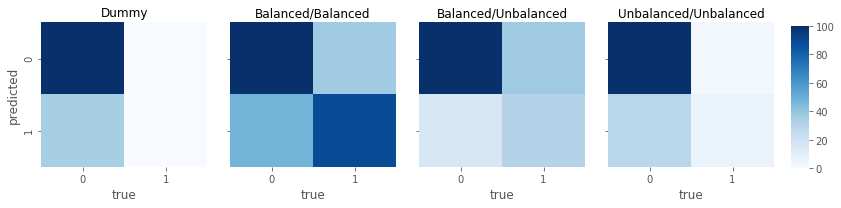

In [45]:
import warnings
warnings.filterwarnings("ignore")

dummy = [[6818856., 0.], [2345839., 0.]]
balbal = [[8568099., 3168797.], [4091001., 7645895.]]
balunbal = [[24822605.,  9272511.], [ 4091001.,  7645895.]]
unbalunbal = [[32951915.,  1143201.], [ 9526153.,  2210743.]]

def add_result(name, values):
    results = pd.DataFrame(columns=('result', 'predicted', 'true', 'count'))
    top = np.max(values)
    results.loc[0] = [name, 0, 0, (values[0][0]/top)*100]
    results.loc[1] = [name, 0, 1, (values[0][1]/top)*100]
    results.loc[2] = [name, 1, 0, (values[1][0]/top)*100]
    results.loc[3] = [name, 1, 1, (values[1][1]/top)*100]
    return results

results = pd.concat([add_result("Dummy", dummy), add_result("Balanced/Balanced", balbal),
                     add_result("Balanced/Unbalanced", balunbal), add_result("Unbalanced/Unbalanced", unbalunbal)])

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(results, col="result")
cbar_ax = fg.fig.add_axes([.92, .2, .02, .66])
fg.map_dataframe(draw_heatmap, 'true', 'predicted', 'count', cbar_ax=cbar_ax, cmap='Blues', vmin=0, vmax=100)
fg.set_titles(col_template="{col_name}", fontsize=18)
fg.fig.subplots_adjust(right=.9) 

In [9]:
results = [[29.93, 0.74, 0.42],[0.85, 0.69, 0.69],[0.96, 0.71, 0.66], [1.61, 0.76, 0.57]]
df = pd.DataFrame(results, columns =['Log Loss','Accuracy', 'f1-score'], index=['Dummy','Balanced/Balanced','Balanced/Unbalanced','Unbalanced/Unbalanced'])
df

,Log Loss,Accuracy,f1-score
Dummy,29.93,0.74,0.42
Balanced/Balanced,0.85,0.69,0.69
Balanced/Unbalanced,0.96,0.71,0.66
Unbalanced/Unbalanced,1.61,0.76,0.57


### Evaluation Takeaway

All of our models beat the dummy classifier, but in different ways. Perhaps the most important, the ability to predict clicks and not simply the majority class (0s), is best exhibited by the model that is trained on balanced data. When we train on an unbalanced dataset, our model becomes essentially a very expensive majority class predictor. That is, it is very hesitant to predict clicks, and instead predicts no clicks for most of the observations. The f1-score is best for the model that is trained on the balanced data, no matter the data for which we are making predictions. 


# 5. Application of Course Concepts

Through addressing the prediction of click through rates, we have applied many of the course concepts from W261: Machine Learning at Scale. Though there were more concepts addressed in the main body of this report, we will focus here on these three: scalability, feature selection, and bias/variance tradeoff.

## 5.1 Scalability

Throughout this work, we have conciously chosen to work with dataframes and the dataframe API in Spark Mllib over working with hand-coded implementations with RDDs. We will refer to the dataframe API in Spark Mllib as Spark ML. Typically, using RDDs coded in Python would allow greater flexibility, but at the cost of serialization/deserialization of the data and code to something Spark can understand. User defined functions (UDFs) suffer from the same setback. Although UDFs may allow for additional flexibility, they require serialization of the data, adding an additional step, and reducing performance. Using Spark ML allows us to take advantage of the optimized functions under the hood, written in Scala to improve performance at scale. 

Using Spark ML provides additional benefits. The Pandas integration is quite convenient for visualization during the EDA as well as printing output cleanly. The pipelining afforded by the Spark ML API allows for easy to follow fits and transformations on train and test datasets. Spark ML has many optimized, built in methods that will be more performant than UDFs. Additionally, Spark has a SparkSQL API allowing for performant dataframe transformations at scale.

When scaling up it is important to guard against executor failure. We accomplish this by occaisional checkpointing in addition to caching of transformed dataframes. If an executor fails, all of the cached transformations go with it. Due to lazy evaluation the entire lineage will have to be reevaluated the next time an action is called on the transformed dataframe. This lineage can be examined in the logical and physical execution plans. Checkpointing saves a dataframe to a temporary location on the disk, so that in case of a failure, we can just read the dataframe from disk. This makes sense when reading from disk is faster than reevaluating all of the transformations previously performed.

## 5.2 Feature Engineering and Selection

We have done quite a bit of feature engineering and selection, presented above, and in the supplementary notebook. For this exercise we had both categorical and numerical columns. For the categorical columns, we created additional features by one-hot encoding. That is, we created a binary column for each unique feature in the categorical fields, encoding each unique feature with a 1 in the feature column, or a 0 if the datapoint took on a different value in the field. One-hot encoded features can then be fed into the logistic regression that we trained. One-hot encoding can result in a tremendous number of features if each field has many unique values, since a single column is created for each unique value. In the particular subset of data we used for EDA, one-hot encoding each of the categorical columns would result in almost 100,000 features. Because of this, we carefully pruned the fields and features to include in our model. We selected which features to keep both as a result of EDA and an optimization function that evaluated many different combinations. 

For the numerical columns, we standardized the vectors by subtracting the mean and dividing by the standard deviation of each column, imputed missing values to the mean, and also added a second column for each numerical feature (and one categorical feature) indicating whether a value was present or not. It is important to standardize the vectors this way so that gradient descent will converge. 

Because we were told the data was in chronological order but could not discern a field that looked like a timestamp, we created a `daypart` column to approximate a 24-hour timestamp using a combination of approximation and calculation.

Before we could feed these features into the logistic regression, we also evaluated the interactions of the fields we had in the initial dataset. It is possible, however,that by including all of the two-way interactions we would end up with an enormous number of features. It would have been possible to implement some sort of field-aware matrix factorization method that would have found latent vectors instead of fitting all of the interaction terms. However, we chose to focus on logistic regression for the sake of interpretability. For the logistic regression, a huge number of features and interactions would result in a model that is both expensive to train, and overfit to the training data. To counteract this, we did not fit all of the interactions, but rather a subset. A deeper discussion of model overfitting can be found in the next section around the bias/variance tradeoff.

## 5.3 Bias/Variance Tradeoff

As models become more complex, the variance between models built with different subsets of data increases. On the other hand, models that are too simple have high bias, or large difference between the true value and the average predicted value for any input. The bias-variance tradeoff refers to the need to find the optimal model with complexity that leads to both acceptable variance and bias.

When examining error, we can "decompose" it into components from bias and variance in addition to the irreducible error.

$Err = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$

In machine learning, imperfect models that are missing terms or include the incorrect terms lead to bias. Finite data leads to variance. Therefore, we must find the right balance between the two. The irreducible error is noise that enters the model that cannot be reduced by gathering more data or building a better model.

$Err = \left(E[\hat{f}(x)]-f(x)\right)^2 + E\left[\left(\hat{f}(x)-E[\hat{f}(x)]\right)^2\right] +\sigma_e^2$

To achieve balance between bias and variance, we can be careful about feature selection. In order to create a model that accurately predicts the output of interest, we must include features that are either directly correlated with the output, or correlated with the output when involved in an interaction with another feature. Including additional features will improve the accuracy on the training set, reducing bias, but including too many will increase the variance of the predictions. 

It is also possible to regularize during gradient descent. Regularization discourages large coefficients by placing a penalty on the coefficients (equations 6-11). When gradient descent is performed with regularization, then the algorithm does not reach the absolute minimum loss for the training set of data, but instead provides a more generalizable model. 

Early stopping can also contribute to lowering the variance of a fitted model. If we do not allow gradient descent to minimize the loss function, but instead stop after a set and small number of iterations, we will fit a model with slightly higher bias, but hopefully with lower variance.

## The great #TODO list

Here, we will address what we would do to continue this project. 

First, we would implement a random forest model in addition to the logistic regression implemented above.

Once we found the optimal model, we would save the model to file. This would allow predictions to be made very quickly for new observations.

Also, we may want to go back and evaluate the data imputation that was done for the numerical features. We imputed to the mean, but it is also possible to use matrix factorization to fill in the null values for the numerical features.

# References

1.Display Advertising Challenge. Available at: https://kaggle.com/c/criteo-display-ad-challenge. (Accessed: 15th April 2019)

2.Factorization Machines & their application on huge datasets (Python code). Available at: https://www.analyticsvidhya.com/blog/2018/01/factorization-machines/?utm_campaign=buffer&utm_content=buffer81252&utm_medium=social&utm_source=twitter.com. (Accessed: 12th April 2019)

3.Hypothesis Representation. Coursera Available at: https://www.coursera.org/learn/machine-learning/supplement/AqSH6/hypothesis-representation. (Accessed: 12th April 2019)

4.Jupyter Notebook Viewer. Available at: https://nbviewer.jupyter.org/urls/dl.dropbox.com/s/r20ff7q0yni5kiu/LogisticRegression-Spark-Notebook.ipynb. (Accessed: 12th April 2019)

5.LogisticRegression (Spark 2.4.0 JavaDoc). Available at: https://spark.apache.org/docs/2.4.0/api/java/org/apache/spark/ml/classification/LogisticRegression.html. (Accessed: 15th April 2019)

6.MLlib: Main Guide - Spark 2.4.1 Documentation. Available at: https://spark.apache.org/docs/latest/ml-guide.html. (Accessed: 12th April 2019)

7.sklearn.linear_model.LogisticRegression — scikit-learn 0.20.3 documentation. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. (Accessed: 15th April 2019)

8.Spark 2.4.1 ScalaDoc - GradientDescent - Spark 2.4.1 ScalaDoc - org.apache.spark.mllib.optimization.GradientDescent. Available at: https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.mllib.optimization.GradientDescent. (Accessed: 12th April 2019)

9.Understanding the Bias-Variance Tradeoff. Available at: http://scott.fortmann-roe.com/docs/BiasVariance.html. (Accessed: 12th April 2019)
